In [33]:
import warnings
warnings.filterwarnings("ignore")
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
#plt.style.use("ggplot")
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from scipy.signal import find_peaks
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


## Time series data can be categorized in various ways based on its characteristics. Here are some common types of time series data:

 #### 1)Univariate vs. Multivariate:
a) Univariate Time Series: Contains single observations recorded sequentially over equal time increments.

b) Multivariate Time Series: Contains multiple observations (variables) recorded sequentially over equal time increments.

 #### 2) Continuous vs. Discrete:
a) Continuous Time Series: Data points are recorded at every moment in a given range.

b) Discrete Time Series: Data points are recorded at specific intervals.

 #### 3) Stationary vs. Non-stationary:
a) Stationary Time Series: Statistical properties (like mean and variance) remain constant over time.

b) Non-stationary Time Series: Statistical properties change over time.

 #### 4)Seasonal vs. Non-seasonal:
a) Seasonal Time Series: Patterns repeat at regular intervals.

b) Non-seasonal Time Series: No repeating patterns or trends.

 #### 5) Cyclical vs. Non-cyclical:
a) Cyclical Time Series: Patterns occur at irregular intervals, typically driven by business/economic cycles.

b) Non-cyclical Time Series: No cyclical patterns.

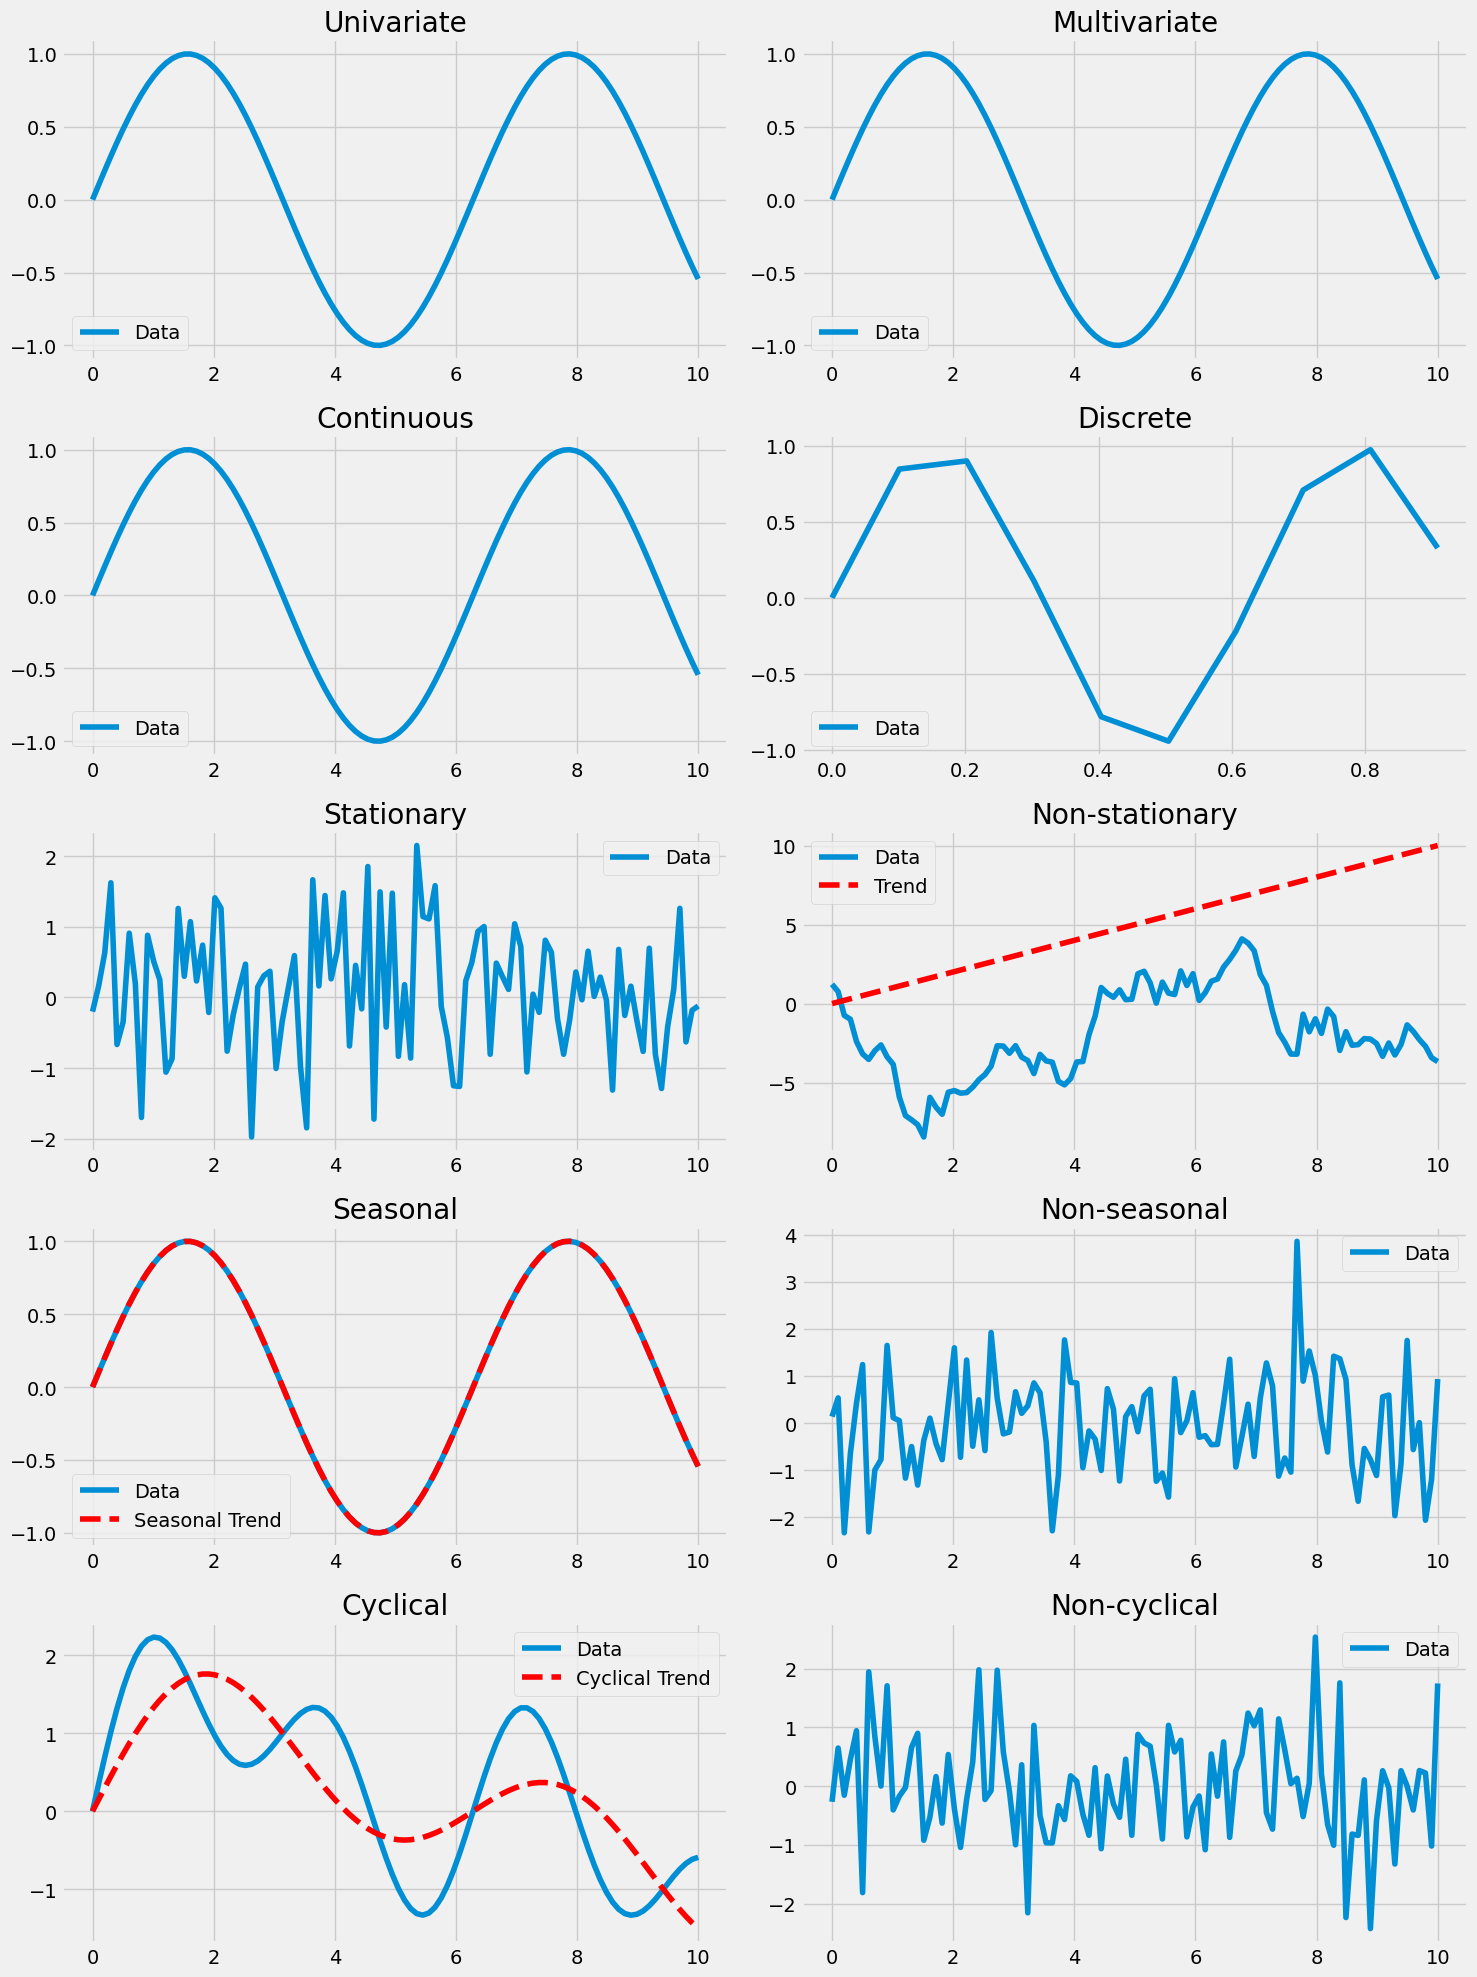

In [34]:
# Sample data generation
t = np.linspace(0, 10, 100)

# Univariate and Multivariate
univariate = np.sin(t)
multivariate = np.column_stack((np.sin(t), np.cos(t)))

# Continuous and Discrete
continuous = np.sin(t)
discrete = continuous[::10]

# Stationary and Non-stationary
stationary = np.random.randn(100)
non_stationary = np.cumsum(np.random.randn(100))

# Seasonal and Non-seasonal
seasonal = np.sin(t)
non_seasonal = np.random.randn(100)

# Cyclical and Non-cyclical
cyclical = np.sin(0.5 * t) + np.sin(t) + np.sin(2 * t)
non_cyclical = np.random.randn(100)

# Visualization
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
titles = ['Univariate', 'Multivariate', 'Continuous', 'Discrete', 'Stationary', 'Non-stationary', 'Seasonal', 'Non-seasonal', 'Cyclical', 'Non-cyclical']
data = [univariate, multivariate[:, 0], continuous, discrete, stationary, non_stationary, seasonal, non_seasonal, cyclical, non_cyclical]

for ax, title, d in zip(axes.ravel(), titles, data):
    ax.plot(t[:len(d)], d, label='Data')
    
    # Adding trend lines where appropriate
    if title == "Non-stationary":
        ax.plot(t[:len(d)], np.linspace(0, 10, len(d)), 'r--', label='Trend')
    if title == "Seasonal":
        ax.plot(t[:len(d)], np.sin(t[:len(d)]), 'r--', label='Seasonal Trend')
    if title == "Cyclical":
        ax.plot(t[:len(d)], np.sin(t[:len(d)]) + np.sin(0.5 * t[:len(d)]), 'r--', label='Cyclical Trend')
    
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()


In [35]:
# Step 1: Read the CSV file
data_path = '/kaggle/input/perrin-freres-monthly-champagne-sales/Perrin Freres monthly champagne sales millions.csv'
df = pd.read_csv(data_path)

## Basic data inspection:

In [36]:
df.head()

Month  Perrin Freres monthly champagne sales millions ?64-?72
0  1964-01                                             2815.0     
1  1964-02                                             2672.0     
2  1964-03                                             2755.0     
3  1964-04                                             2721.0     
4  1964-05                                             2946.0

In [37]:
df.tail()

Month  \
102                                            1972-07   
103                                            1972-08   
104                                            1972-09   
105                                                NaN   
106  Perrin Freres monthly champagne sales millions...   

     Perrin Freres monthly champagne sales millions ?64-?72  
102                                             4298.0       
103                                             1413.0       
104                                             5877.0       
105                                                NaN       
106                                                NaN

In [38]:
df.rename(columns={"Perrin Freres monthly champagne sales millions ?64-?72": "Sales"}, inplace=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   106 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [40]:
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')
df.set_index('Month', inplace=True)


In [41]:
df.head()

Sales
Month             
1964-01-01  2815.0
1964-02-01  2672.0
1964-03-01  2755.0
1964-04-01  2721.0
1964-05-01  2946.0

#### Data Cleaning

In [42]:
missing_rows = df[df.isnull().any(axis=1)]
missing_rows.head()

Sales
Month       
NaT      NaN
NaT      NaN

In [43]:
#  Checking for missing values
missing_row = df.isnull().sum()
missing_row

Sales    2
dtype: int64

In [44]:
df.shape

(107, 1)

In [45]:
#  Removing rows with missing values
df = df.dropna().copy()

# Verifying that all the missing values have been removed
missing_rows  = df.isnull().sum()
missing_rows


Sales    0
dtype: int64

In [46]:
#  Summary Statistics
df.describe().T


count         mean          std     min     25%     50%     75%  \
Sales  105.0  4761.152381  2553.502601  1413.0  3113.0  4217.0  5221.0   

           max  
Sales  13916.0

#### Count: 

There are 105 data points.

#### Mean: 

The average monthly sales are approximately 4761 million units.

#### Standard Deviation: 

The sales have a standard deviation of approximately 2553.5 million units, indicating variability in sales.

#### Min: 

The minimum monthly sales recorded is 1413 million units.

25% (First Quartile): 25% of the data points have sales less than or equal to 3113 million units.

#### Median (50%):

The median sales value is 4217 million units.

#### 75% (Third Quartile):

75% of the data points have sales less than or equal to 5221 million units.

#### Max: 

The maximum monthly sales recorded is 13916 million 

## Step 1:  Visualizing the Time Series Data

In [47]:
df.shape

(105, 1)

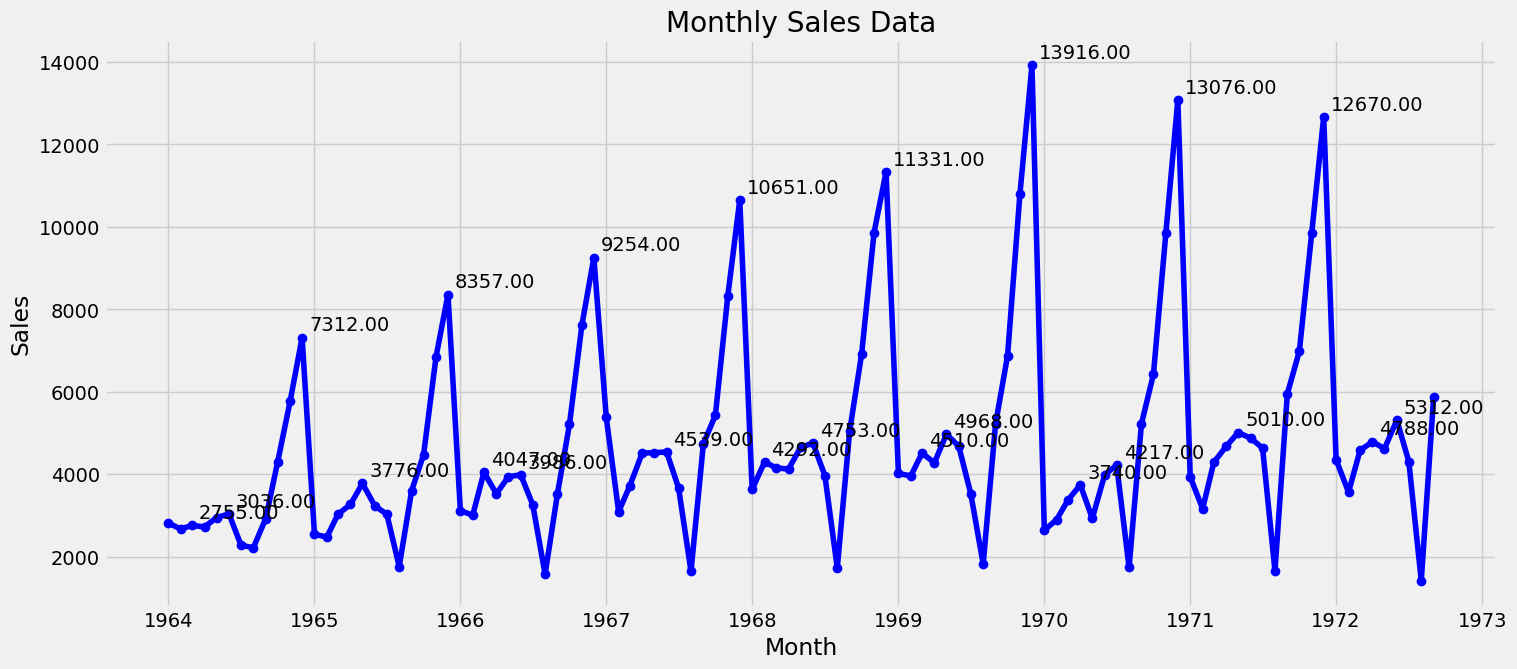

In [48]:
from scipy.signal import find_peaks

plt.figure(figsize=(16, 7))  # Set the figure size
plt.plot(df["Sales"], marker='o', linestyle='-', color='b')  # Plot the sales data

plt.title('Monthly Sales Data')  # Add a title
plt.xlabel('Month')  # Add x-axis label
plt.ylabel('Sales')  # Add y-axis label
plt.grid(True)  # Add gridlines

# Finding peaks in the sales data
peaks, _ = find_peaks(df['Sales'])

# Adding annotations for the peaks
for peak in peaks:
    plt.annotate(f'{df["Sales"].iloc[peak]:.2f}', xy=(df.index[peak], df['Sales'].iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

plt.show()


## The plot reveals a few interesting insights:

## Seasonality: 
        There is a clear seasonal pattern in the sales data. Sales tend to spike at certain periods of the year, likely corresponding to the holiday season.
## Trend:
        There seems to be an upward trend in sales over the years, indicating growth.
## Variability:
        The magnitude of the seasonal spikes appears to be growing over time, suggesting increasing variability in sales.

## Analysis of Champagne Sales Trends Across Different Time Frames

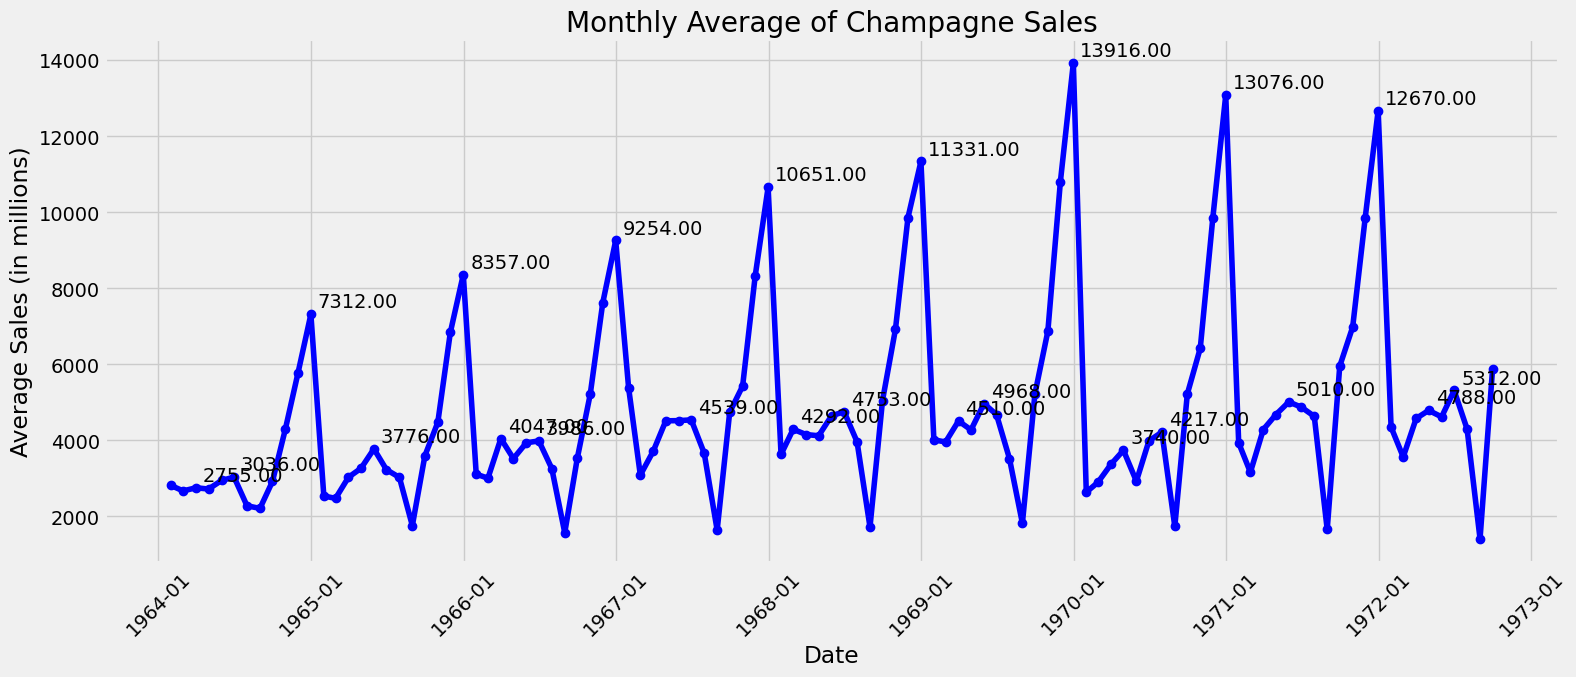

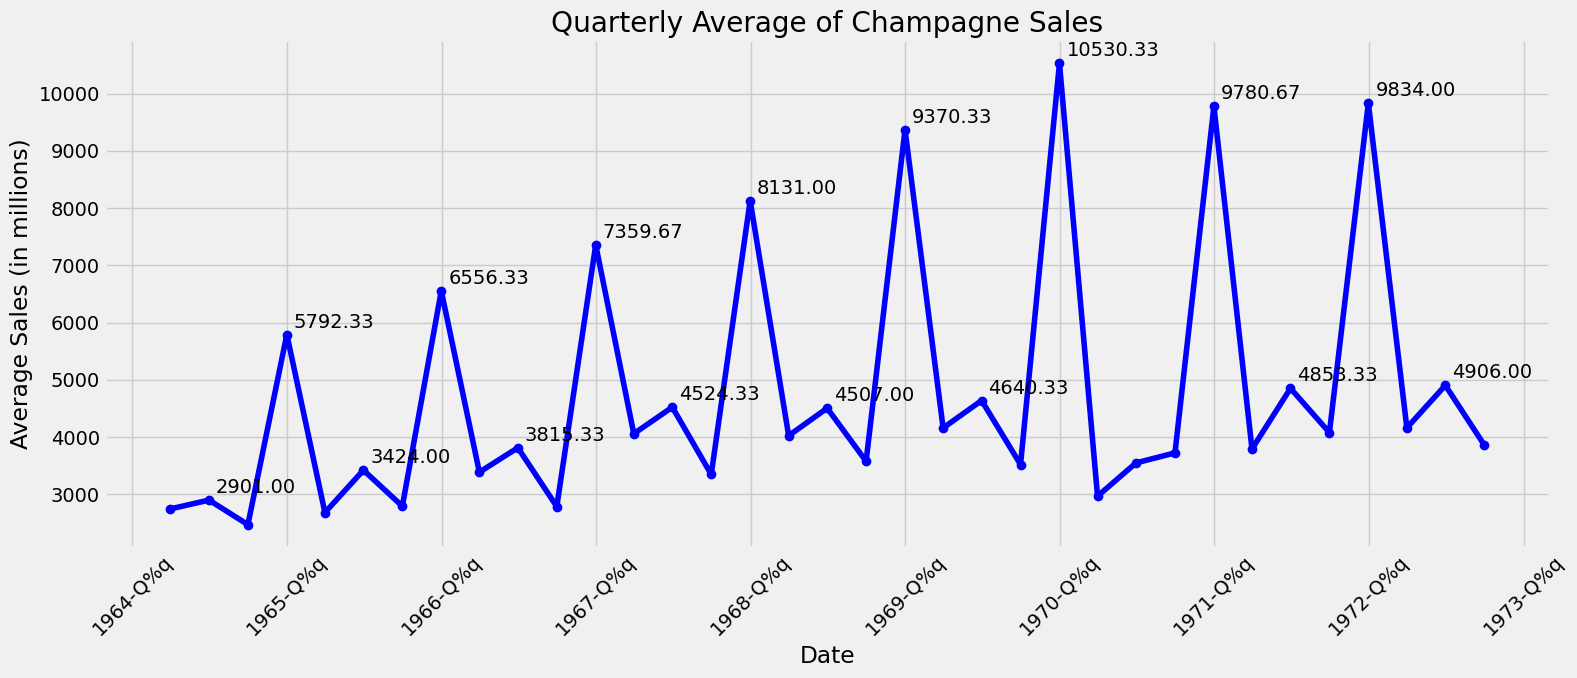

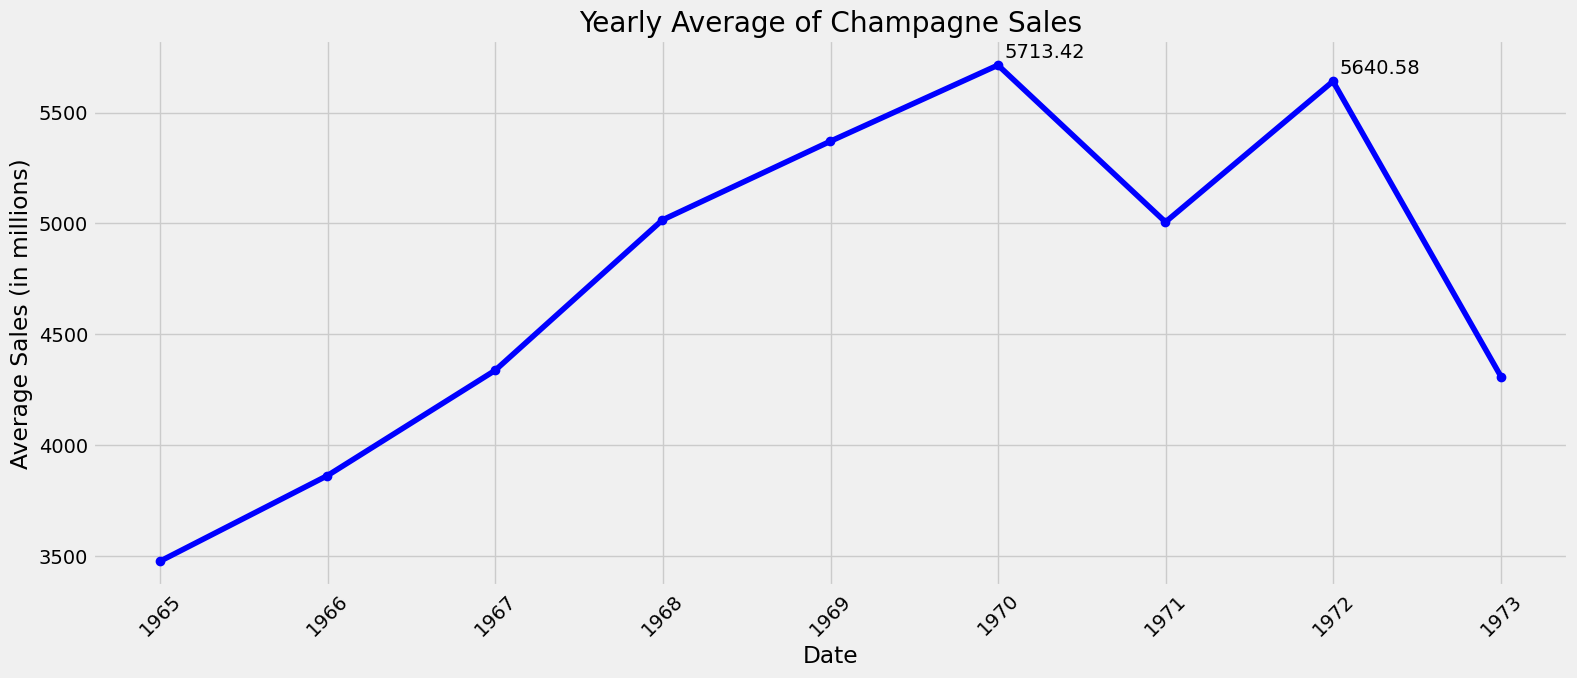

In [49]:
# Defining the different frequencies for resampling
frequencies = ['M', 'Q', 'A']  # 'M' for Monthly, 'Q' for Quarterly, 'A' for Annually
titles = ['Monthly', 'Quarterly', 'Yearly']  # Titles for the plots
date_formats = ['%Y-%m', '%Y-Q%q', '%Y']  # Date formats for monthly, quarterly, and yearly

# Looping through each frequency and creating a plot for resampled Champagne Sales
for freq, title, date_format in zip(frequencies, titles, date_formats):
    # Resampling the data
    # This resamples the dataframe  according to the specified frequency and calculates the mean
    resampled_data = df.resample(freq).mean()
    
    # figure for the plot
    plt.figure(figsize=(16, 7))
    
    # Plotting the resampled data for Champagne Sales
    # 'resampled_data.index' gives the resampled dates
    # 'resampled_data['Sales']' gives the corresponding sales values
    plt.plot(resampled_data.index, resampled_data['Sales'], marker='o', color='blue')
    
    # Finding peaks in the resampled data
    peaks, _ = find_peaks(resampled_data['Sales'])
    # Adding sales annotations at peaks
    for peak in peaks:
        plt.annotate(f'{resampled_data["Sales"].iloc[peak]:.2f}', xy=(resampled_data.index[peak], resampled_data['Sales'].iloc[peak]), 
                     xytext=(5, 5), textcoords='offset points')

    # Setting the title of the plot
    plt.title(f'{title} Average of Champagne Sales')
    
    # Labeling the x-axis
    plt.xlabel('Date')
    
    # Labeling the y-axis
    plt.ylabel('Average Sales (in millions)')
    
    # Adding a grid to the plot for better readability
    plt.grid(True)
    
    # Formatting the x-axis labels according to the specified date format
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(date_format))
    
    # Rotating the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjusting the layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    # Displaying the plot
    plt.show()


In [50]:
dff = df.copy()

## Enhance Time Series Data with Date-Time Attributes

In [51]:
def add_datetime_attributes(df):
    """
    Creating time series features with respect to the time series index.
    """
    return df.assign(
        #hour=df.index.hour,
        dayofweek=df.index.dayofweek,
        quarter=df.index.quarter,
        month=df.index.month,
        year=df.index.year,
        dayofyear=df.index.dayofyear,
        #dayofmonth=df.index.day,
        weekofyear=df.index.isocalendar().week
    )


In [52]:
dff = df.copy()
dff = add_datetime_attributes(dff).copy()

# Display the DataFrame with the new features
dff.head(10)


Sales  dayofweek  quarter  month  year  dayofyear  weekofyear
Month                                                                     
1964-01-01  2815.0          2        1      1  1964          1           1
1964-02-01  2672.0          5        1      2  1964         32           5
1964-03-01  2755.0          6        1      3  1964         61           9
1964-04-01  2721.0          2        2      4  1964         92          14
1964-05-01  2946.0          4        2      5  1964        122          18
1964-06-01  3036.0          0        2      6  1964        153          23
1964-07-01  2282.0          2        3      7  1964        183          27
1964-08-01  2212.0          5        3      8  1964        214          31
1964-09-01  2922.0          1        3      9  1964        245          36
1964-10-01  4301.0          3        4     10  1964        275          40

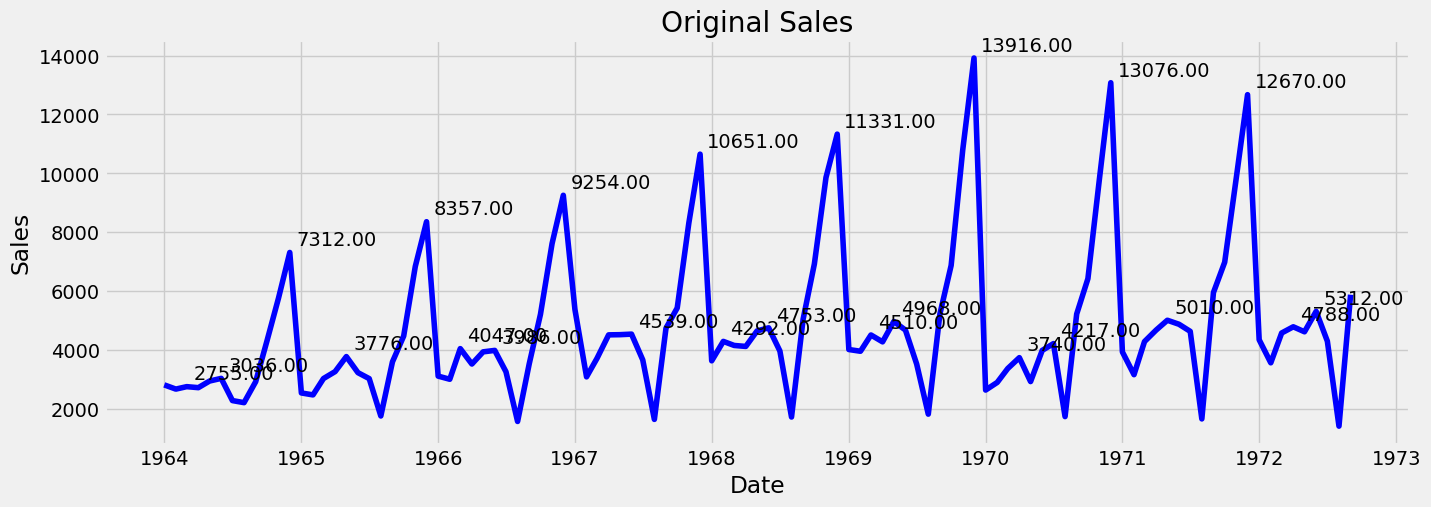

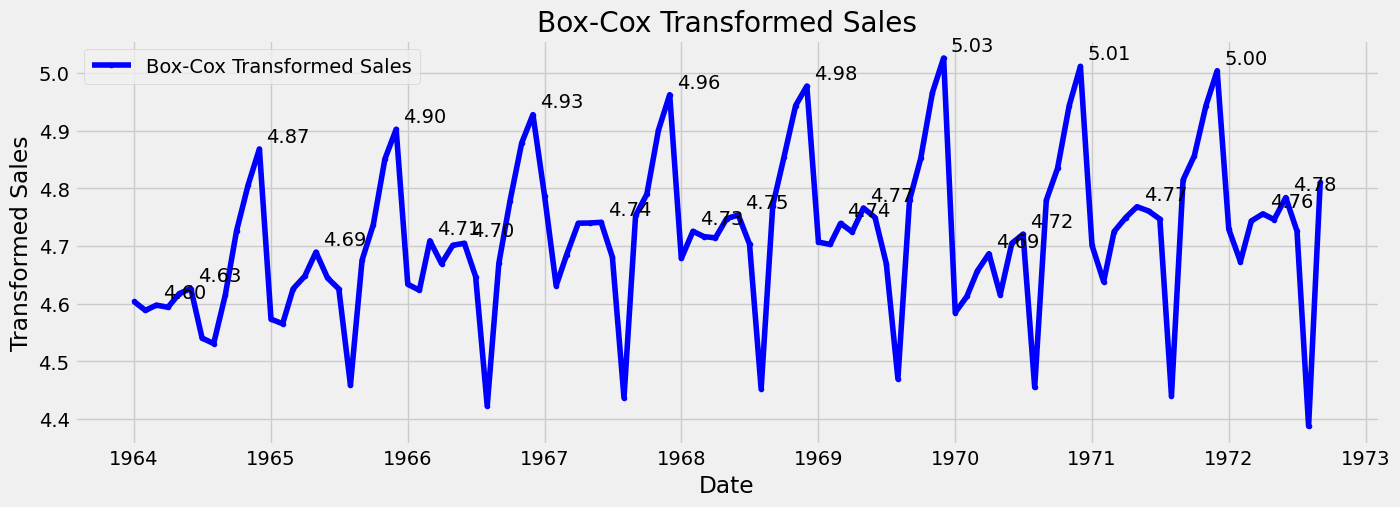

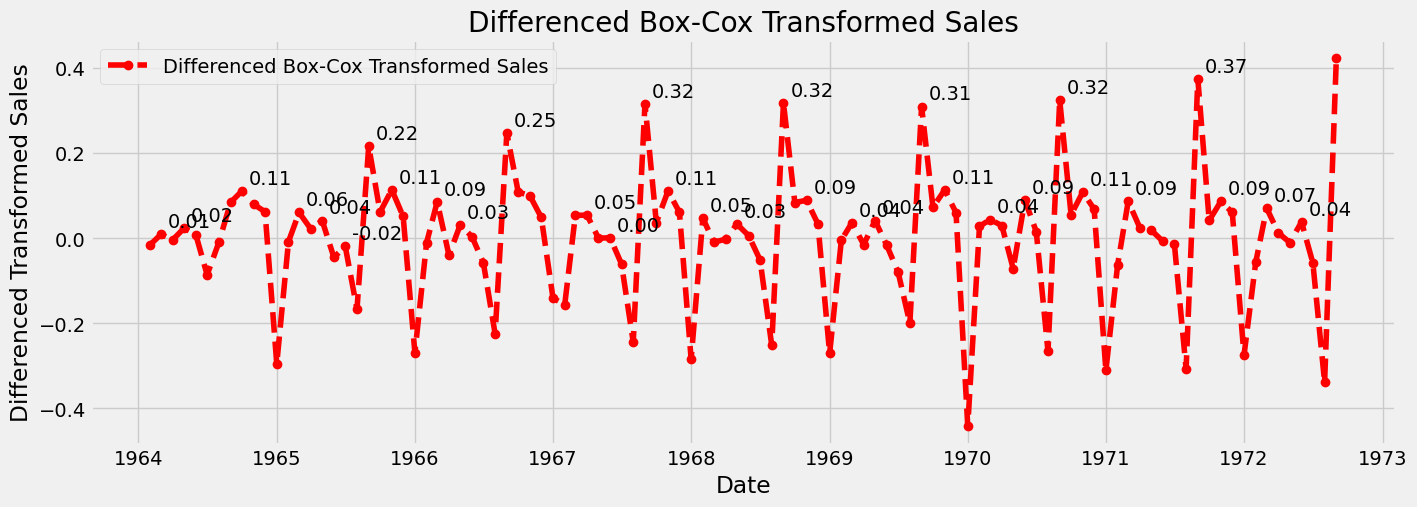

In [53]:
from scipy.stats import boxcox
from scipy.signal import find_peaks

# Checking for non-positive values and shifting the data if necessary
if (df['Sales'] <= 0).any():
    min_value = df['Sales'].min()
    shift_value = abs(min_value) + 1
    df['Sales'] = df['Sales'] + shift_value
else:
    shift_value = 0

# Plotting the original sales data
plt.figure(figsize=(15, 5))
plt.plot(df['Sales'], color='blue')
plt.title('Original Sales')
plt.ylabel('Sales')
plt.xlabel('Date')

# Finding peaks
peaks, _ = find_peaks(df['Sales'])

# Adding sales annotations at peaks
for peak in peaks:
    plt.annotate(f'{df["Sales"].iloc[peak]:.2f}', xy=(df.index[peak], df['Sales'].iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

plt.show()

# Step 1: Apply Box-Cox Transformation to stabilize the variance and store the transformed data and lambda
df['Sales_Transformed'], fitted_lambda = boxcox(df['Sales'])

# Plotting the Box-Cox Transformed Data
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Sales_Transformed'], label='Box-Cox Transformed Sales', marker='.', linestyle='-', color='blue')
plt.title('Box-Cox Transformed Sales')
plt.xlabel('Date')
plt.ylabel('Transformed Sales')
plt.legend()

# Finding peaks in the transformed data
peaks_transformed, _ = find_peaks(df['Sales_Transformed'])

# Adding sales annotations at peaks in transformed data
for peak in peaks_transformed:
    plt.annotate(f'{df["Sales_Transformed"].iloc[peak]:.2f}', xy=(df.index[peak], df['Sales_Transformed'].iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

plt.show()

# Step 2: Apply Differencing to the Box-Cox Transformed Data to remove the trend component
df['Sales_Transformed_Diff'] = df['Sales_Transformed'].diff()

# Visualizing the Differenced Transformed Data
plt.figure(figsize=(15, 5))
diff_index = df['Sales_Transformed_Diff'].dropna().index
plt.plot(diff_index, df['Sales_Transformed_Diff'].dropna(), label='Differenced Box-Cox Transformed Sales', linestyle='--', marker='o', color='red')
plt.title('Differenced Box-Cox Transformed Sales')
plt.xlabel('Date')
plt.ylabel('Differenced Transformed Sales')
plt.legend()

# Finding peaks in the differenced transformed data
peaks_diff, _ = find_peaks(df['Sales_Transformed_Diff'].dropna())

# Adding sales annotations at peaks in differenced transformed data
for peak in peaks_diff:
    plt.annotate(f'{df["Sales_Transformed_Diff"].dropna().iloc[peak]:.2f}', xy=(df['Sales_Transformed_Diff'].dropna().index[peak], df['Sales_Transformed_Diff'].dropna().iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

plt.show()


In [54]:
df.head()

Sales  Sales_Transformed  Sales_Transformed_Diff
Month                                                        
1964-01-01  2815.0           4.603834                     NaN
1964-02-01  2672.0           4.588251               -0.015584
1964-03-01  2755.0           4.597409                0.009159
1964-04-01  2721.0           4.593696               -0.003713
1964-05-01  2946.0           4.617329                0.023633

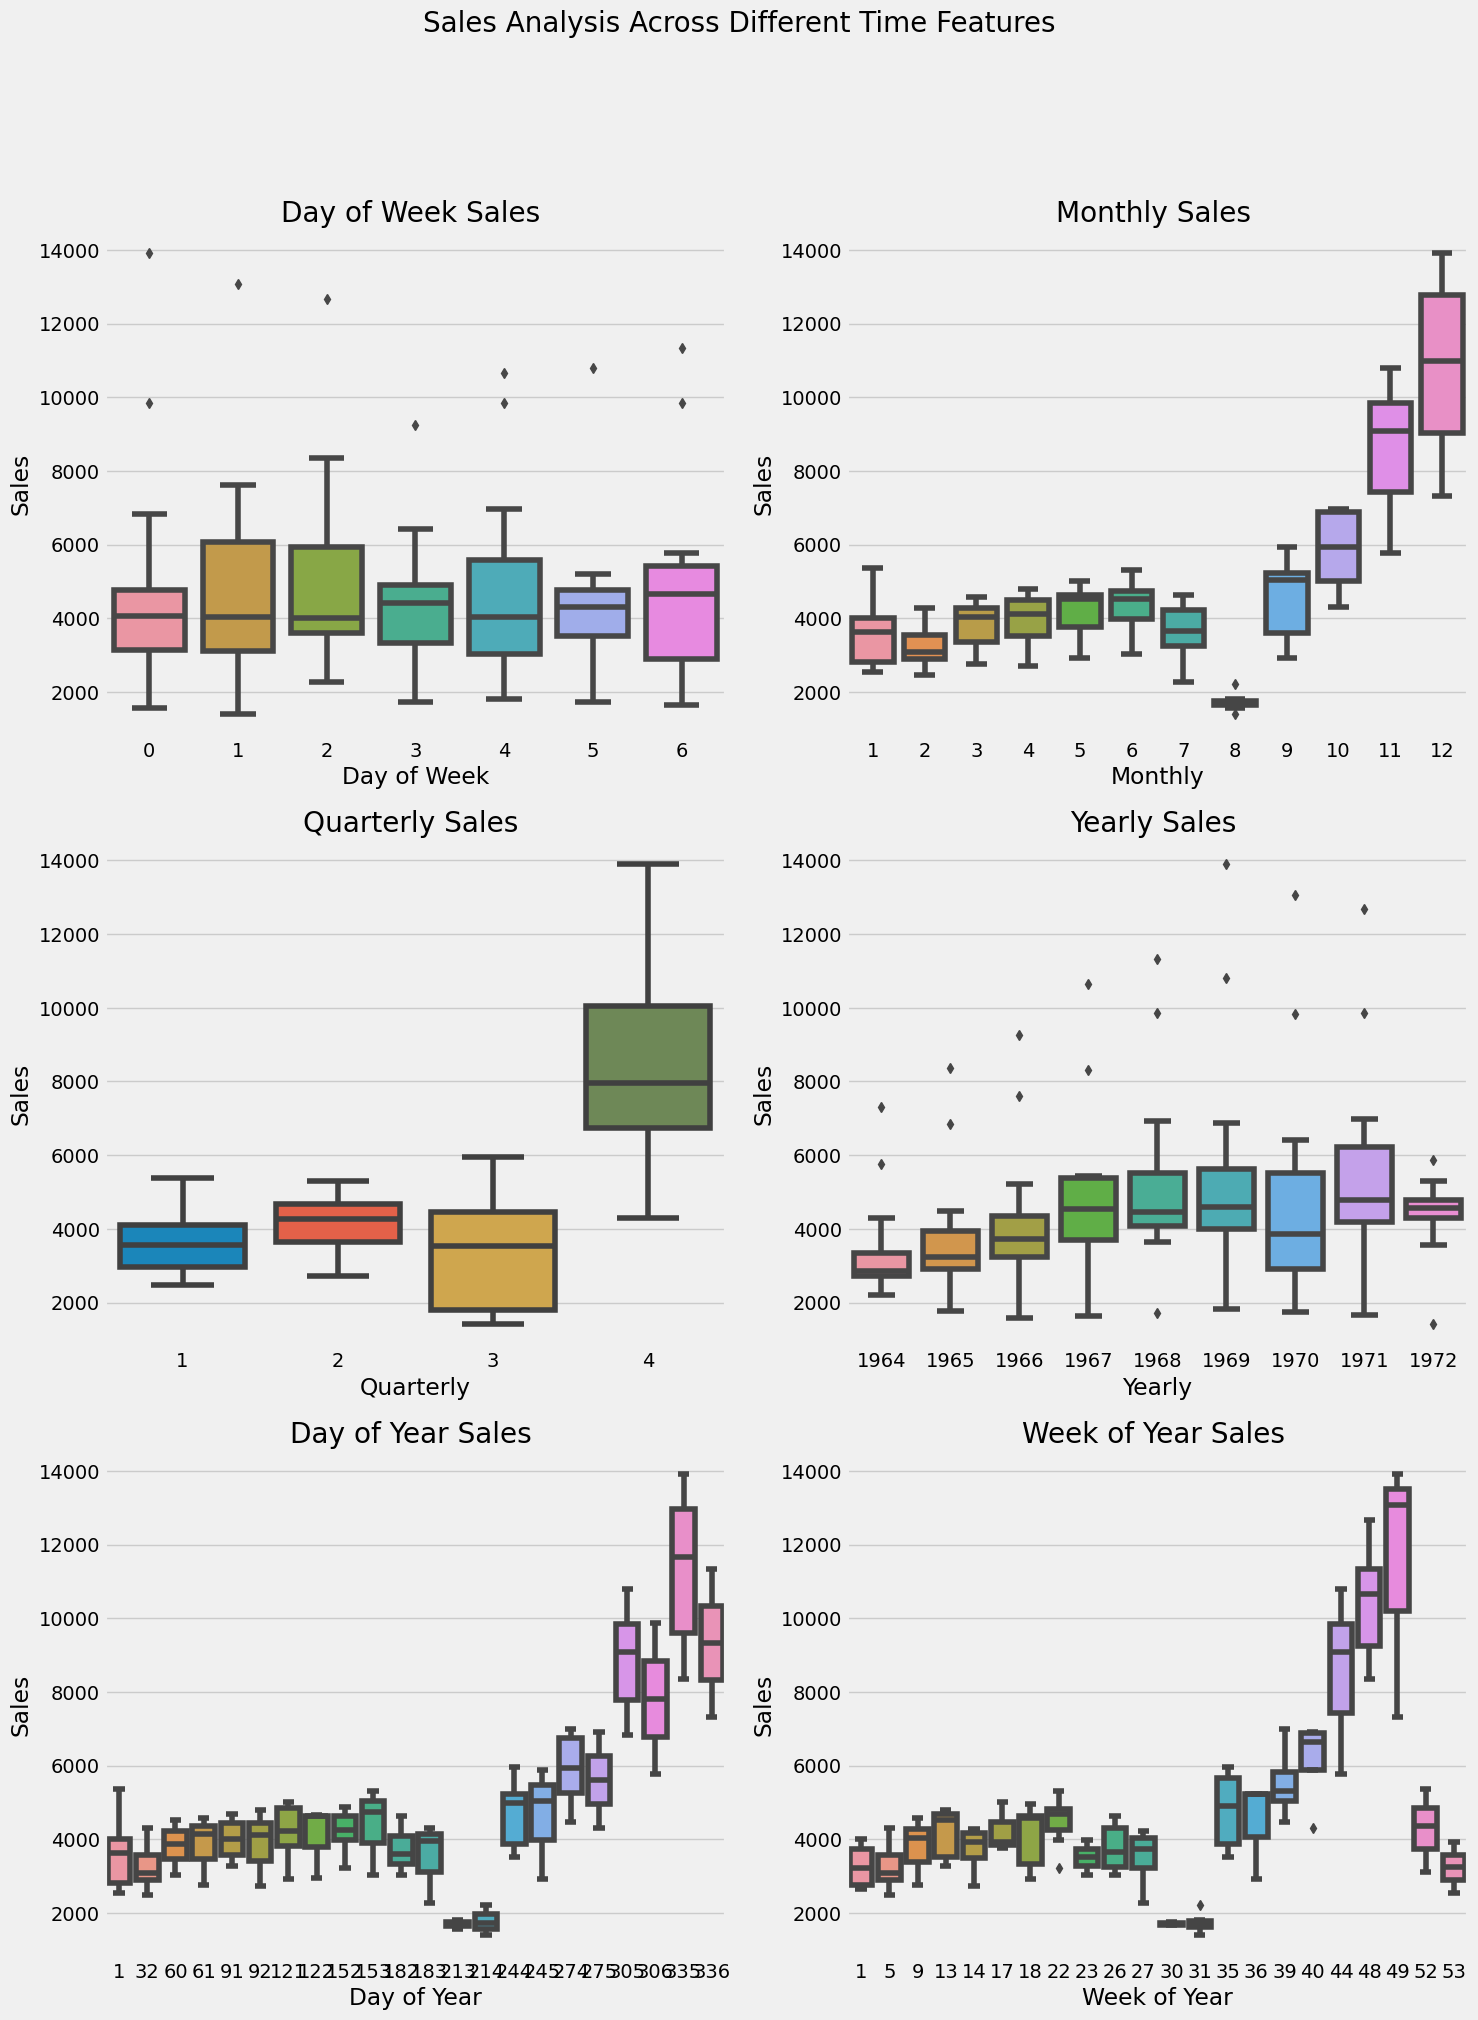

In [55]:
# Listing of time features and their corresponding labels for plotting
time_features = [
    ('dayofweek', 'Day of Week'),
    ('month', 'Monthly'),
    ('quarter', 'Quarterly'),
    ('year', 'Yearly'),
    ('dayofyear', 'Day of Year'),
    ('weekofyear', 'Week of Year')
]

# Setting up the figure to accommodate a 6x2 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 40)) 
fig.suptitle('Sales Analysis Across Different Time Features', fontsize=20)  # Overall title

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Looping through each time feature and its corresponding subplot
for i, (feature, label) in enumerate(time_features):
    sns.boxplot(data=dff, x=feature, y='Sales', ax=axes[i])  # Use 'ax' to specify subplot location
    axes[i].set_title(f'{label} Sales ')  # Set title for each subplot
    axes[i].set_ylabel('Sales')  # Set Y-axis label
    axes[i].set_xlabel(label)  # Set X-axis label

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to prevent overlap
plt.show()


### Testing for Stationarity

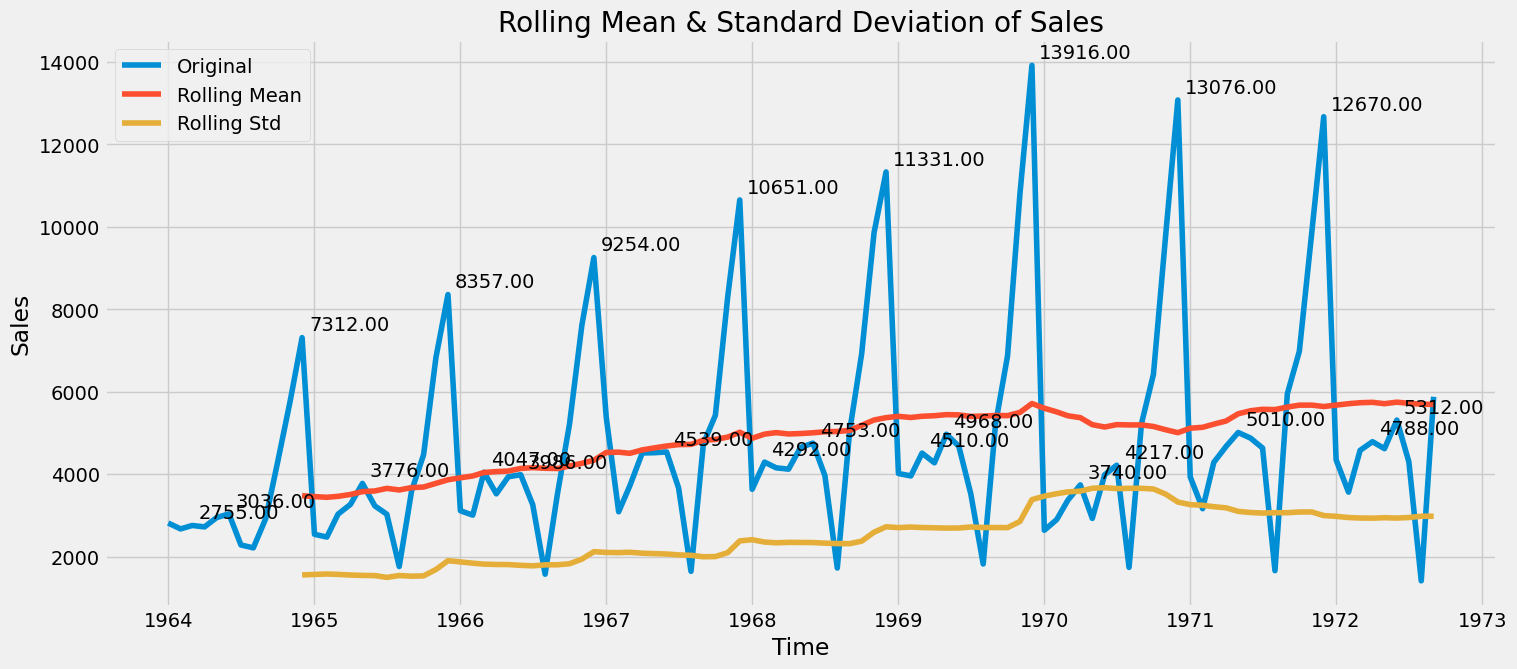

In [56]:
# Calculating the rolling mean and standard deviation
rolling_mean = df['Sales'].rolling(window=12).mean()
rolling_std = df['Sales'].rolling(window=12).std()

# Defining the data to plot
data_to_plot = {
    'Original': df['Sales'],  # Plotting only the 'Sales' column
    'Rolling Mean': rolling_mean,
    'Rolling Std': rolling_std
}

# Creating the plot
fig, ax = plt.subplots(figsize=(16, 7))
for label, data in data_to_plot.items():
    ax.plot(data, label=label)

# Finding peaks in the original sales data
peaks, _ = find_peaks(df['Sales'])
# Adding annotations for the peaks
for peak in peaks:
    ax.annotate(f'{df["Sales"].iloc[peak]:.2f}', xy=(df.index[peak], df['Sales'].iloc[peak]), 
                xytext=(5, 5), textcoords='offset points')

ax.set_title('Rolling Mean & Standard Deviation of Sales')
ax.legend(loc='best')
plt.xlabel('Time')  
plt.ylabel('Sales')
plt.show()


In [57]:
# Function to perform Augmented Dickey-Fuller test with interpretation
def Dickey_Fuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    output = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Interpretation based on p-value
    if result[1] <= 0.05:
        print("Substantial evidence contradicts the null hypothesis, leading to its rejection. The data demonstrates stability, lacking a unit root.")
    else:
        print("Minimal evidence challenges the null hypothesis, suggesting the presence of a unit root in the time series, indicative of its non-stationary nature.")

    return output

# Perform Augmented Dickey-Fuller test on 'Sales' column
adf_test_result = Dickey_Fuller_test(df['Sales'])

print(adf_test_result)


Minimal evidence challenges the null hypothesis, suggesting the presence of a unit root in the time series, indicative of its non-stationary nature.
ADF Test Statistic             -1.833593
p-value                         0.363916
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


## The results of the Augmented Dickey-Fuller (ADF) test are as follows:

ADF Statistic: -1.8336

P-value: 0.3639

Critical Values:
1%: -3.5027
5%: -2.8932
10%: -2.5836


Based on the ADF test, since the test statistic (-1.8336) is greater than the critical values and

the p-value is greater than 0.05, we fail to reject the null hypothesis.

This means the time series is likely non-stationary.

11 lags were used, which means the test looked at the correlation of the time series with its own past values up to 11 periods back.

Here,  observations were used for the test.  This is the number of data points used in the analysis after adjusting for the lags.

##  Now, to further validate our observations, I perform a seasonal decomposition.



Decomposing the Time Series for Seasonality and Trend:

To observe the seasonality, trend, and residual components of the time series, 

we can use the seasonal_decompose function from the statsmodels library.

Let's decompose the time series and visualize its components.​

##  Decomposition:

Decomposing the time series into its components:

## Trend: 
The underlying trend in the data.

## Seasonal: 
The repeating short-term cycle in the series.

## Residual:
The random variation in the series.

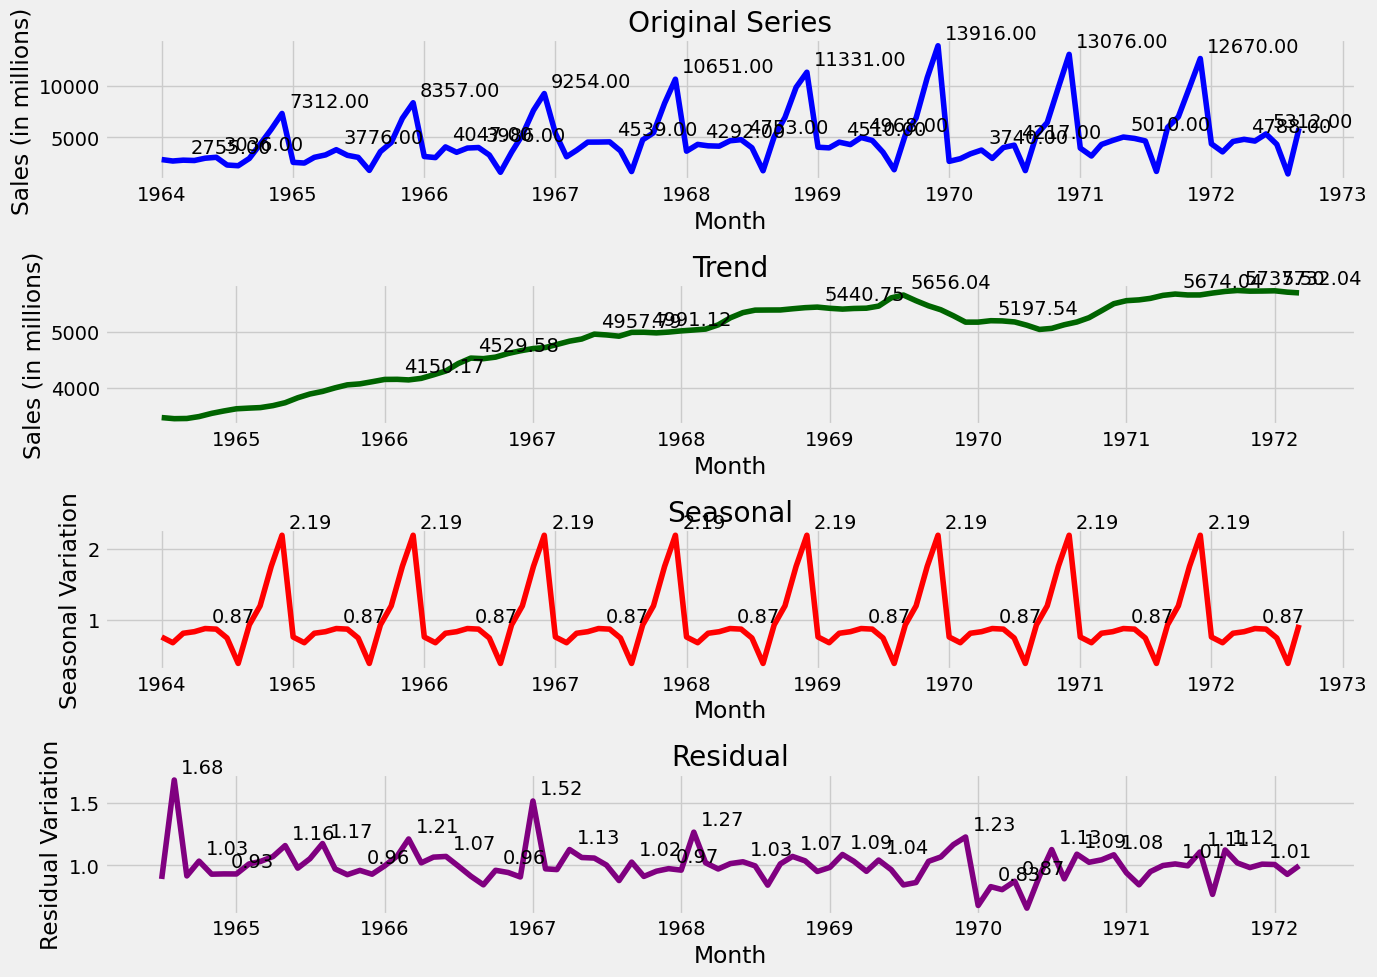

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks

# Decomposing the time series to its various components
decomposition = seasonal_decompose(df['Sales'], model='multiplicative', period=12)  # yearly seasonality with monthly data

# Plotting the decomposed components
plt.figure(figsize=(14, 10))

# Original
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Sales'], color='blue')
plt.title('Original Series')
plt.xlabel('Month')
plt.ylabel('Sales (in millions)')

# Adding annotations for the original series
peaks, _ = find_peaks(df['Sales'])
for peak in peaks:
    plt.annotate(f'{df["Sales"].iloc[peak]:.2f}', xy=(df.index[peak], df['Sales'].iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

# Trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend.index, decomposition.trend, color='darkgreen')
plt.title('Trend')
plt.xlabel('Month')
plt.ylabel('Sales (in millions)')

# Adding annotations for the trend component
if decomposition.trend.dropna().any():
    trend = decomposition.trend.dropna()
    peaks, _ = find_peaks(trend)
    for peak in peaks:
        plt.annotate(f'{trend.iloc[peak]:.2f}', xy=(trend.index[peak], trend.iloc[peak]), 
                     xytext=(5, 5), textcoords='offset points')

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal.index, decomposition.seasonal, color='red')
plt.title('Seasonal')
plt.xlabel('Month')
plt.ylabel('Seasonal Variation')

# Adding annotations for the seasonal component
if decomposition.seasonal.dropna().any():
    seasonal = decomposition.seasonal.dropna()
    peaks, _ = find_peaks(seasonal)
    for peak in peaks:
        plt.annotate(f'{seasonal.iloc[peak]:.2f}', xy=(seasonal.index[peak], seasonal.iloc[peak]), 
                     xytext=(5, 5), textcoords='offset points')

# Residual
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid.index, decomposition.resid, color='purple')
plt.title('Residual')
plt.xlabel('Month')
plt.ylabel('Residual Variation')

# Adding annotations for the residual component
if decomposition.resid.dropna().any():
    resid = decomposition.resid.dropna()
    peaks, _ = find_peaks(resid)
    for peak in peaks:
        plt.annotate(f'{resid.iloc[peak]:.2f}', xy=(resid.index[peak], resid.iloc[peak]), 
                     xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


#### From the above plots the seasonal decomposition provides further insights into the time series:

#### Trend:    

The trend component shows a gradual increase in sales over the years, confirming our earlier observation of growth.
#### Seasonal: 

The seasonal component clearly shows a repeating pattern every year. There's a significant spike, which likely corresponds to the holiday season, followed by a                    drop.This seasonality is consistent throughout the years.
#### Residual:  

The residuals represent the noise or randomness in the data after removing the trend and seasonal components. They seem to be randomly distributed without any                      discernible pattern, which is a good sign.

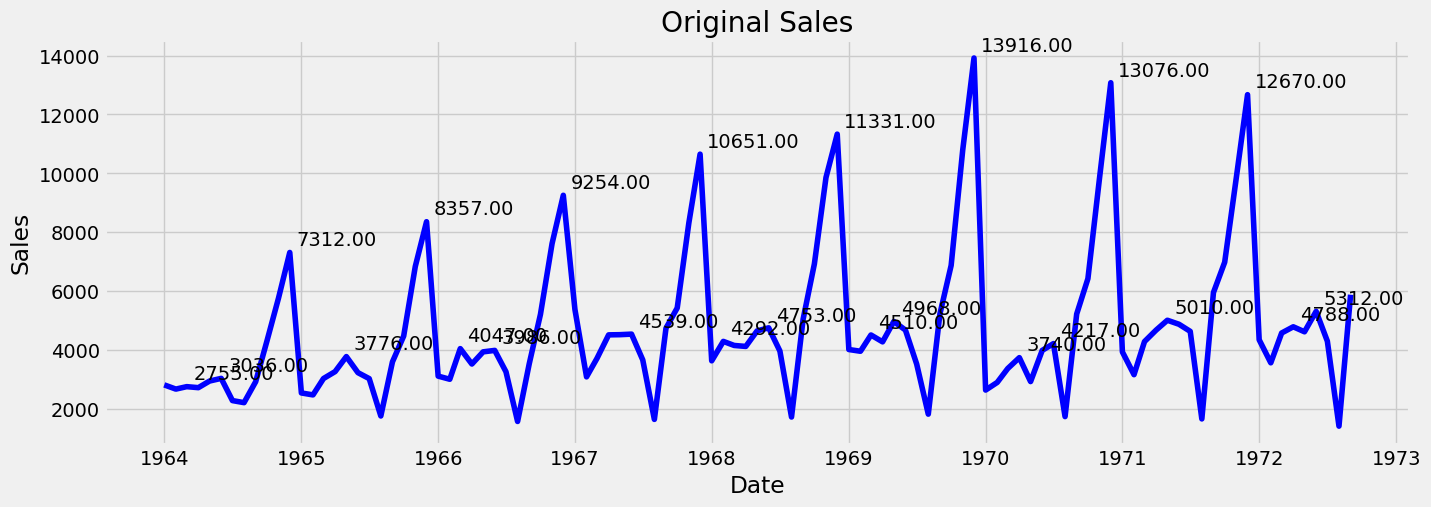

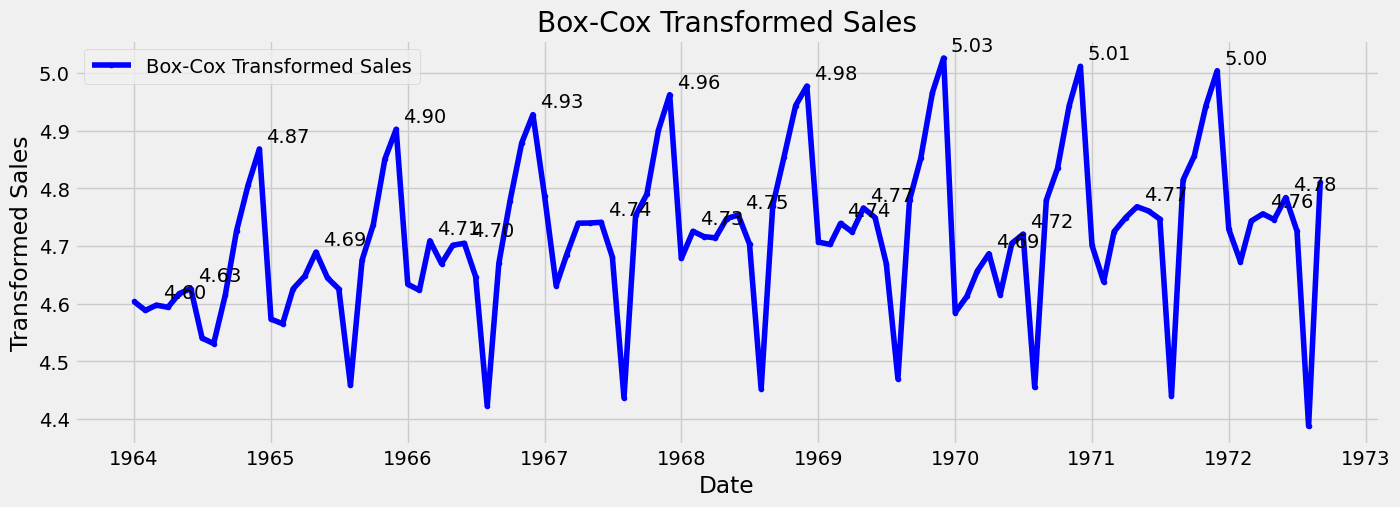

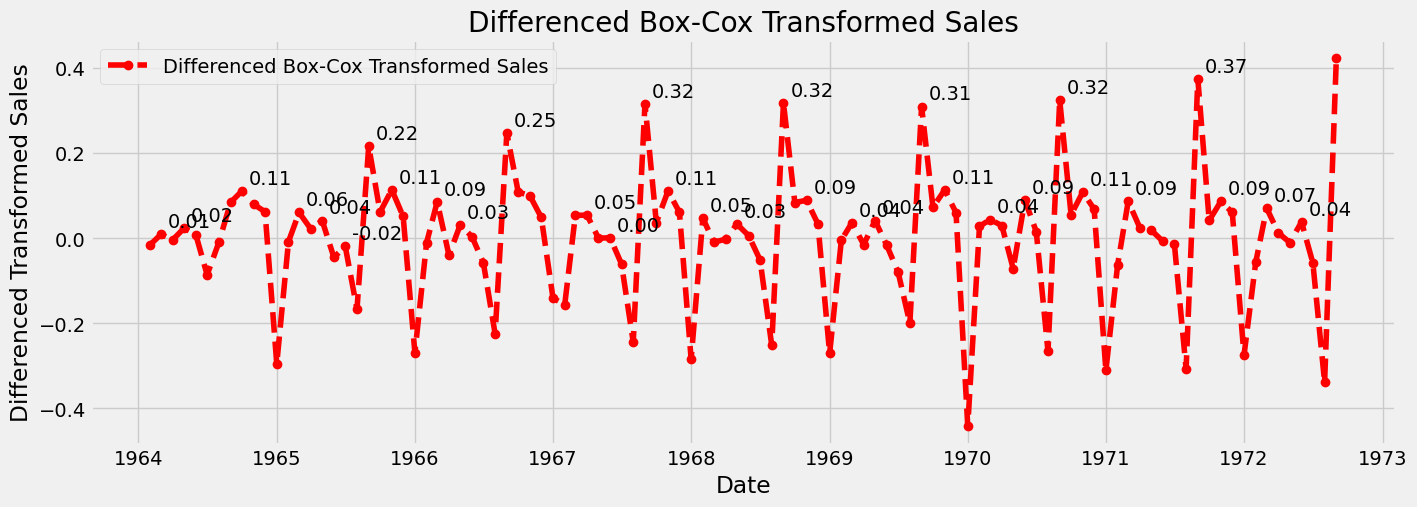

In [59]:
from scipy.stats import boxcox
from scipy.signal import find_peaks

# Checking for non-positive values and shifting the data if necessary
if (df['Sales'] <= 0).any():
    min_value = df['Sales'].min()
    shift_value = abs(min_value) + 1
    df['Sales'] = df['Sales'] + shift_value
else:
    shift_value = 0

# Plotting the original sales data
plt.figure(figsize=(15, 5))
plt.plot(df['Sales'], color='blue')
plt.title('Original Sales')
plt.ylabel('Sales')
plt.xlabel('Date')

# Finding peaks
peaks, _ = find_peaks(df['Sales'])

# Adding sales annotations at peaks
for peak in peaks:
    plt.annotate(f'{df["Sales"].iloc[peak]:.2f}', xy=(df.index[peak], df['Sales'].iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

plt.show()

# Step 1: Apply Box-Cox Transformation to stabilize the variance and store the transformed data and lambda
df['Sales_Transformed'], fitted_lambda = boxcox(df['Sales'])

# Plotting the Box-Cox Transformed Data
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Sales_Transformed'], label='Box-Cox Transformed Sales', marker='.', linestyle='-', color='blue')
plt.title('Box-Cox Transformed Sales')
plt.xlabel('Date')
plt.ylabel('Transformed Sales')
plt.legend()

# Finding peaks in the transformed data
peaks_transformed, _ = find_peaks(df['Sales_Transformed'])

# Adding sales annotations at peaks in transformed data
for peak in peaks_transformed:
    plt.annotate(f'{df["Sales_Transformed"].iloc[peak]:.2f}', xy=(df.index[peak], df['Sales_Transformed'].iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

plt.show()

# Step 2: Apply Differencing to the Box-Cox Transformed Data to remove the trend component
df['Sales_Transformed_Diff'] = df['Sales_Transformed'].diff()

# Visualizing the Differenced Transformed Data
plt.figure(figsize=(15, 5))
diff_index = df['Sales_Transformed_Diff'].dropna().index
plt.plot(diff_index, df['Sales_Transformed_Diff'].dropna(), label='Differenced Box-Cox Transformed Sales', linestyle='--', marker='o', color='red')
plt.title('Differenced Box-Cox Transformed Sales')
plt.xlabel('Date')
plt.ylabel('Differenced Transformed Sales')
plt.legend()

# Finding peaks in the differenced transformed data
peaks_diff, _ = find_peaks(df['Sales_Transformed_Diff'].dropna())

# Adding sales annotations at peaks in differenced transformed data
for peak in peaks_diff:
    plt.annotate(f'{df["Sales_Transformed_Diff"].dropna().iloc[peak]:.2f}', xy=(df['Sales_Transformed_Diff'].dropna().index[peak], df['Sales_Transformed_Diff'].dropna().iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

plt.show()


## Box Cox  Transformation to make the variance constant

In [60]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Apply the Box-Cox transformation and store the transformed data in a new column
df['Sales_Transformed'], fitted_lambda = boxcox(df['Sales'])

# At this point, df['Sales_Transformed'] contains the Box-Cox transformed sales data,
# and you have the lambda value used for the transformation

# To invert the Box-Cox transformation (for example, to revert forecasts to the original scale),
# you would use the transformed data and the fitted lambda value
df['Sales_Original_Scale'] = inv_boxcox(df['Sales_Transformed'], fitted_lambda)

# Now, df['Sales_Original_Scale'] contains the sales data reverted back to its original scale


In [61]:
df.dropna(inplace=True)

In [62]:
df.head()

Sales  Sales_Transformed  Sales_Transformed_Diff  \
Month                                                           
1964-02-01  2672.0           4.588251               -0.015584   
1964-03-01  2755.0           4.597409                0.009159   
1964-04-01  2721.0           4.593696               -0.003713   
1964-05-01  2946.0           4.617329                0.023633   
1964-06-01  3036.0           4.626206                0.008877   

            Sales_Original_Scale  
Month                             
1964-02-01                2672.0  
1964-03-01                2755.0  
1964-04-01                2721.0  
1964-05-01                2946.0  
1964-06-01                3036.0

In [63]:
fitted_lambda

-0.15254236136287797

In [64]:
df['Sales_Transformed']

Month
1964-02-01    4.588251
1964-03-01    4.597409
1964-04-01    4.593696
1964-05-01    4.617329
1964-06-01    4.626206
                ...   
1972-05-01    4.745779
1972-06-01    4.784020
1972-07-01    4.725845
1972-08-01    4.387456
1972-09-01    4.811126
Name: Sales_Transformed, Length: 104, dtype: float64

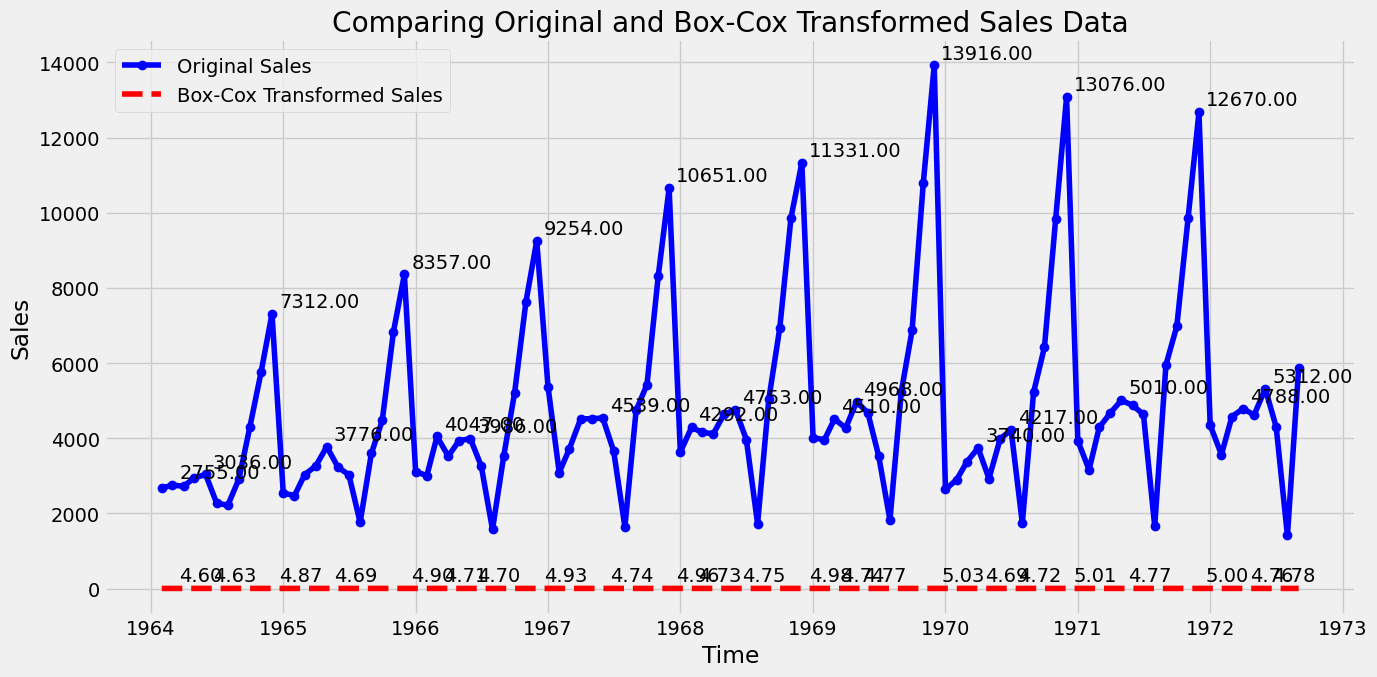

In [65]:
# Plotting the original vs. transformed data to visualize the effect
plt.figure(figsize=(14, 7))

# Plotting the original sales data
plt.plot(df.index, df['Sales_Original_Scale'], label='Original Sales', marker='o', color='blue')

# Plotting the Box-Cox transformed sales data
plt.plot(df.index, df['Sales_Transformed'], label='Box-Cox Transformed Sales', linestyle='--', color='red')

# Adding annotations for the original sales data peaks
peaks_original, _ = find_peaks(df['Sales_Original_Scale'])
for peak in peaks_original:
    plt.annotate(f'{df["Sales_Original_Scale"].iloc[peak]:.2f}', xy=(df.index[peak], df['Sales_Original_Scale'].iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

# Adding annotations for the transformed sales data peaks
peaks_transformed, _ = find_peaks(df['Sales_Transformed'])
for peak in peaks_transformed:
    plt.annotate(f'{df["Sales_Transformed"].iloc[peak]:.2f}', xy=(df.index[peak], df['Sales_Transformed'].iloc[peak]), 
                 xytext=(5, 5), textcoords='offset points')

plt.title('Comparing Original and Box-Cox Transformed Sales Data')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [66]:
# Display the DataFrame with the transformed sales
df_transformed = df[['Sales_Original_Scale', 'Sales_Transformed']]
print(df_transformed.head())


            Sales_Original_Scale  Sales_Transformed
Month                                              
1964-02-01                2672.0           4.588251
1964-03-01                2755.0           4.597409
1964-04-01                2721.0           4.593696
1964-05-01                2946.0           4.617329
1964-06-01                3036.0           4.626206


##  Differencing to remove the trend component

In [67]:

# Apply Box-Cox Transformation and store the transformed data and lambda
df['Sales_Transformed'], fitted_lambda = boxcox(df['Sales'])

# Apply Differencing to the Box-Cox Transformed Data
df['Sales_Transformed_Diff'] = df['Sales_Transformed'].diff()


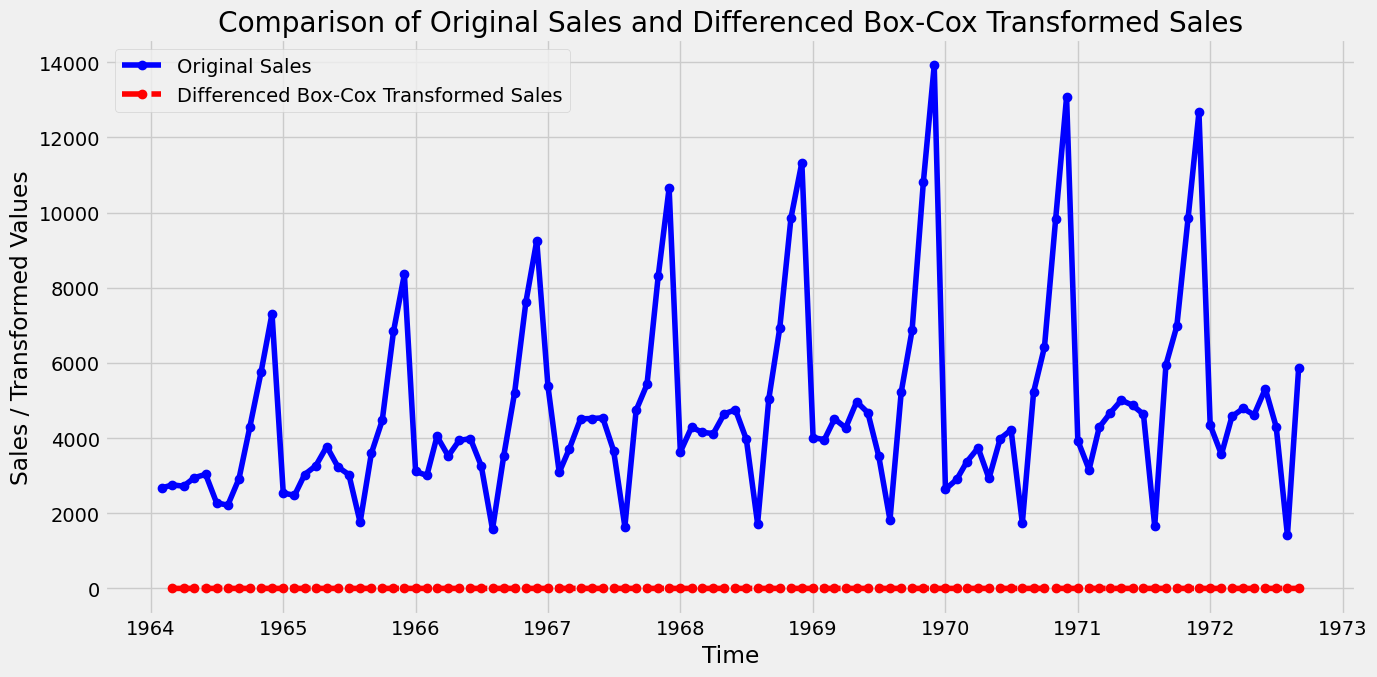

In [68]:
# Visualizing both original sales and differenced transformed data for comparison
plt.figure(figsize=(14, 7))

# Plotting the original 'Sales' data
plt.plot(df.index, df['Sales'], label='Original Sales', marker='o', color='blue')

# Plotting the differenced Box-Cox transformed 'Sales' data
plt.plot(df.index, df['Sales_Transformed_Diff'], label='Differenced Box-Cox Transformed Sales', linestyle='--', marker='o', color='red')

plt.title('Comparison of Original Sales and Differenced Box-Cox Transformed Sales')
plt.xlabel('Time')
plt.ylabel('Sales / Transformed Values')
plt.legend()
plt.tight_layout()
plt.show()


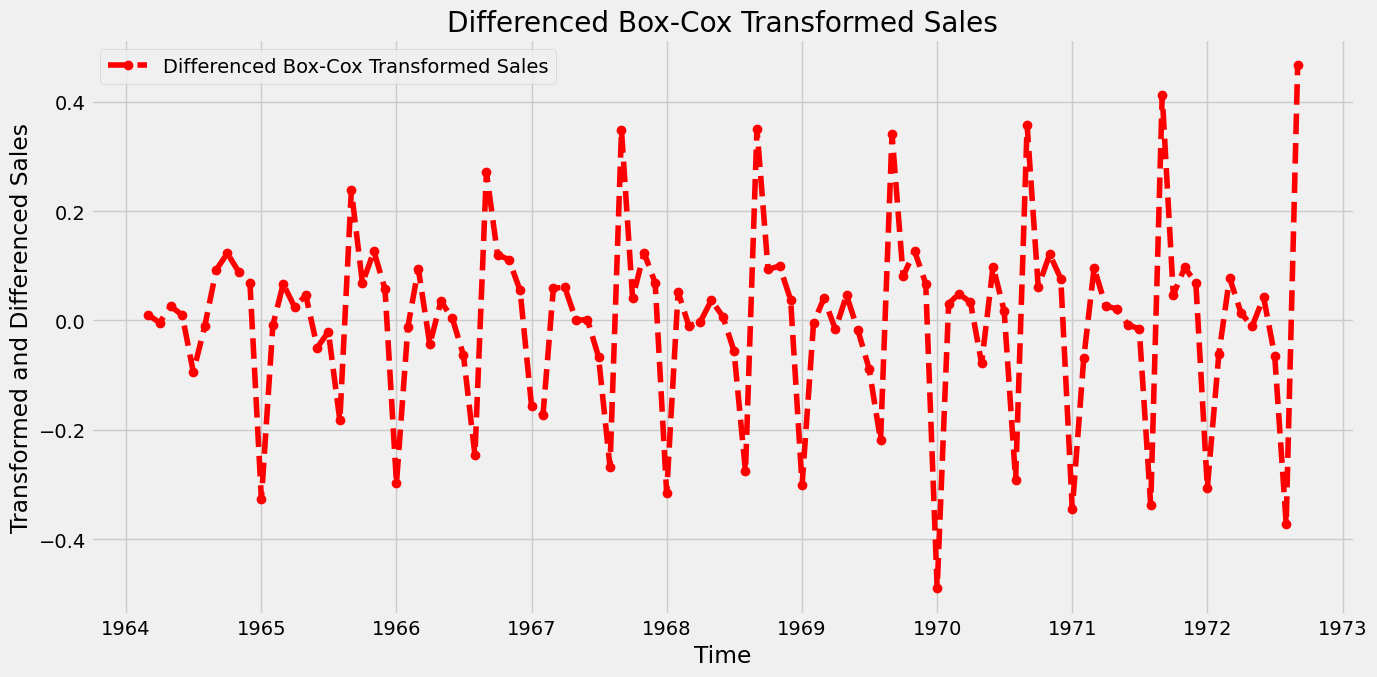

In [69]:
# Step 1: Apply Box-Cox Transformation and store the transformed data and lambda
df['Sales_Transformed'], fitted_lambda = boxcox(df['Sales'])

# Step 2: Apply Differencing to the Box-Cox Transformed Data
df['Sales_Transformed_Diff'] = df['Sales_Transformed'].diff()

# Visualizing the differenced transformed data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales_Transformed_Diff'], label='Differenced Box-Cox Transformed Sales', linestyle='--', marker='o', color='red')
plt.title('Differenced Box-Cox Transformed Sales')
plt.xlabel('Time')
plt.ylabel('Transformed and Differenced Sales')
plt.legend()
plt.tight_layout()
plt.show()


##  Function to perform Augmented Dickey-Fuller test with interpretation to show stationary 

In [70]:
df.dropna(inplace=True)

In [71]:
# Function to perform Augmented Dickey-Fuller test with interpretation
def Dickey_Fuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    output = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Interpretation based on p-value
    if result[1] <= 0.05:
        print("Substantial evidence contradicts the null hypothesis, leading to its rejection. The data demonstrates stability, lacking a unit root.")
    else:
        print("Minimal evidence challenges the null hypothesis, suggesting the presence of a unit root in the time series, indicative of its non-stationary nature.")

    return output

# Perform Augmented Dickey-Fuller test on 'Sales_Transformed_Diff' column
adf_test_result = Dickey_Fuller_test(df['Sales_Transformed_Diff'])

print(adf_test_result)


Substantial evidence contradicts the null hypothesis, leading to its rejection. The data demonstrates stability, lacking a unit root.
ADF Test Statistic             -4.359692
p-value                         0.000350
#Lags Used                     12.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


## Interpretation of Results:

#### ADF Test Statistic: A more negative value indicates stronger evidence against the null hypothesis of a unit root.

#### p-value: A p-value less than 0.05 suggests rejecting the null hypothesis, indicating the series is stationary.

#### Critical Values: Compare the ADF test statistic to the critical values at the 1%, 5%, and 10% levels to determine stationarity.

## Split the Data into Training and Testing Sets

In [72]:
df.head()

Sales  Sales_Transformed  Sales_Transformed_Diff  \
Month                                                           
1964-03-01  2755.0           4.778237                0.010071   
1964-04-01  2721.0           4.774154               -0.004083   
1964-05-01  2946.0           4.800155                0.026001   
1964-06-01  3036.0           4.809927                0.009773   
1964-07-01  2282.0           4.715528               -0.094399   

            Sales_Original_Scale  
Month                             
1964-03-01                2755.0  
1964-04-01                2721.0  
1964-05-01                2946.0  
1964-06-01                3036.0  
1964-07-01                2282.0

Training data points: 82
Testing data points: 21


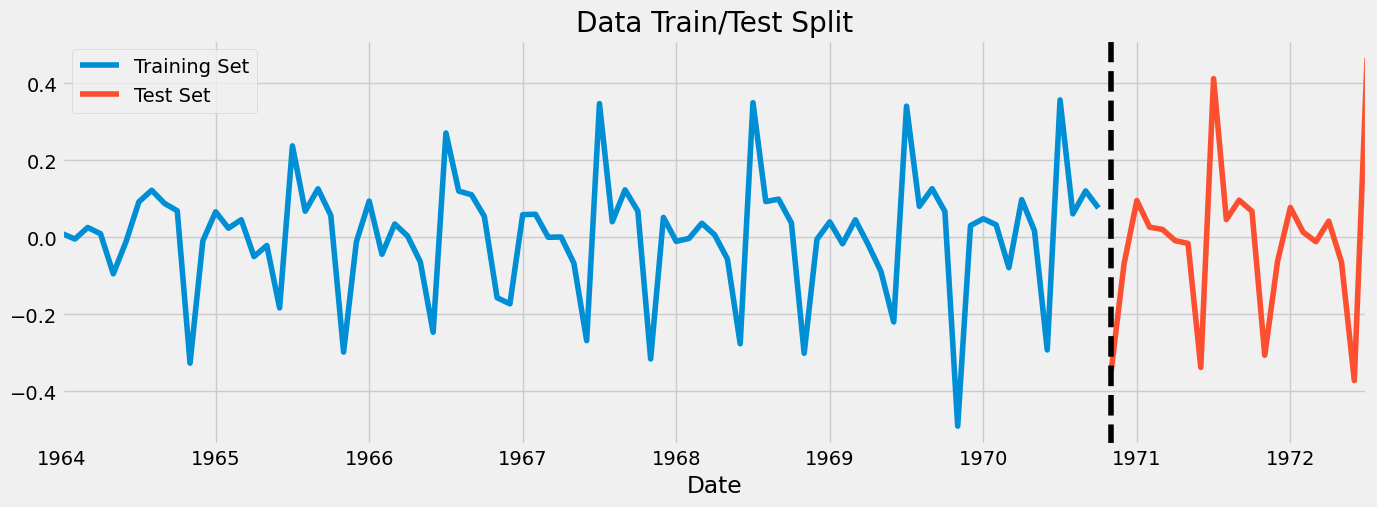

In [73]:
# Add a 'Date' column with monthly periods starting from '01/03/1964'
df['Date'] = pd.date_range(start='01/03/1964', periods=len(df), freq='M')
df.set_index('Date', inplace=True)

# Define the split point (80% for training, 20% for testing)
split_point = int(len(df) * 0.8)
train, test = df[:split_point], df[split_point:]

print(f"Training data points: {len(train)}")
print(f"Testing data points: {len(test)}")

# Plot the train/test split
fig, ax = plt.subplots(figsize=(15, 5))
train['Sales_Transformed_Diff'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['Sales_Transformed_Diff'].plot(ax=ax, label='Test Set')
ax.axvline(df.index[split_point], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [74]:
# Define the add_datetime_attributes function
def add_datetime_attributes(df):
    df['dayofyear'] = df.index.dayofyear
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekofyear'] = df.index.isocalendar().week.astype(int)  # Convert weekofyear to int
    return df


In [75]:
# Ensure the index is in datetime format (this is just a safeguard)
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

# Apply the function to the train and test dataframes
train = add_datetime_attributes(train)
test = add_datetime_attributes(test)

# Verify the columns in the dataframes
print("Train columns:", train.columns)
print("Test columns:", test.columns)

# Define features and target
FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'weekofyear']
TARGET = 'Sales_Transformed_Diff'


Train columns: Index(['Sales', 'Sales_Transformed', 'Sales_Transformed_Diff',
       'Sales_Original_Scale', 'dayofyear', 'dayofweek', 'quarter', 'month',
       'year', 'weekofyear'],
      dtype='object')
Test columns: Index(['Sales', 'Sales_Transformed', 'Sales_Transformed_Diff',
       'Sales_Original_Scale', 'dayofyear', 'dayofweek', 'quarter', 'month',
       'year', 'weekofyear'],
      dtype='object')


In [76]:

# Separate features and target
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Print the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (82, 6)
y_train shape: (82,)
X_test shape: (21, 6)
y_test shape: (21,)


In [77]:
# Define the XGBoost regressor
reg = xgb.XGBRegressor(
    base_score=0.5, 
    booster='gbtree',    
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:squarederror',  # Updated to 'reg:squarederror' as 'reg:linear' is deprecated
    max_depth=3,
    learning_rate=0.01
)

# Fit the model
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# Predict on the test set
y_pred = reg.predict(X_test)

# Print the evaluation results
print("Model Training and Evaluation Complete")


[0]	validation_0-rmse:0.51288	validation_1-rmse:0.54599
[100]	validation_0-rmse:0.21027	validation_1-rmse:0.23741
[200]	validation_0-rmse:0.09834	validation_1-rmse:0.12679
[300]	validation_0-rmse:0.06085	validation_1-rmse:0.09530
[400]	validation_0-rmse:0.04829	validation_1-rmse:0.08903
[500]	validation_0-rmse:0.04217	validation_1-rmse:0.08565
[600]	validation_0-rmse:0.03885	validation_1-rmse:0.08406
[700]	validation_0-rmse:0.03606	validation_1-rmse:0.08346
[795]	validation_0-rmse:0.03291	validation_1-rmse:0.08400
Model Training and Evaluation Complete


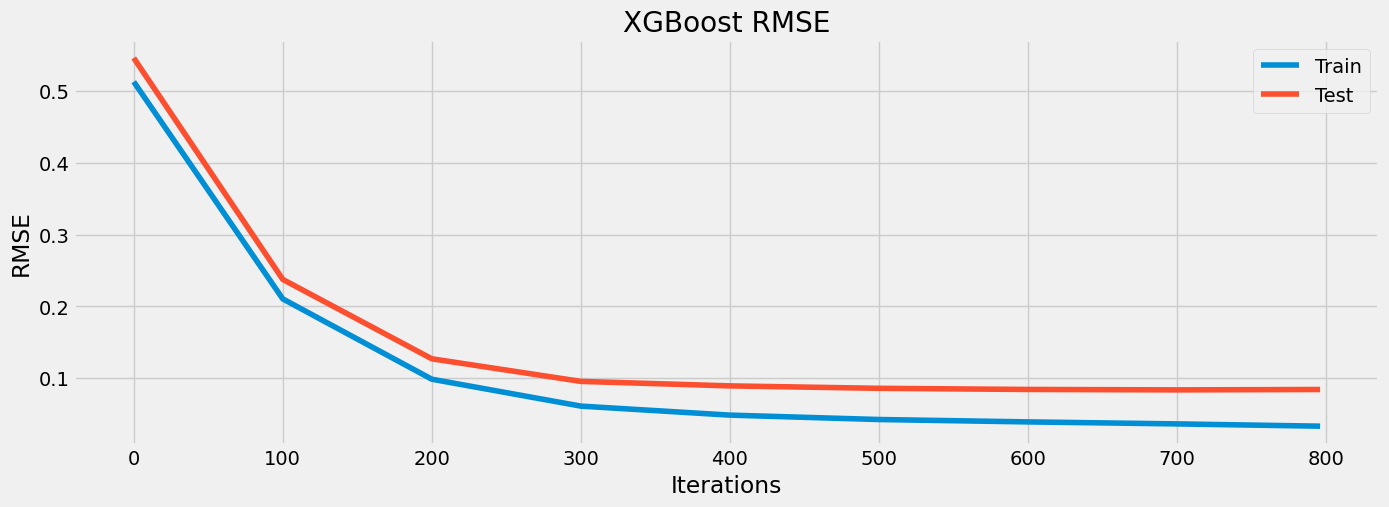

In [78]:
import matplotlib.pyplot as plt

# Provided RMSE values at different iterations
iterations = [0, 100, 200, 300, 400, 500, 600, 700, 796]
train_rmse = [0.51288, 0.21027, 0.09834, 0.06085, 0.04829, 0.04217, 0.03885, 0.03606, 0.03289]
test_rmse = [0.54599, 0.23741, 0.12679, 0.09530, 0.08903, 0.08565, 0.08406, 0.08346, 0.08399]

# Plot the training and validation RMSE
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(iterations, train_rmse, label='Train')
ax.plot(iterations, test_rmse, label='Test')
ax.legend()
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()


##  Determine ARIMA Parameters  from Plot ACF and PACF

In [80]:
import statsmodels.api as sm

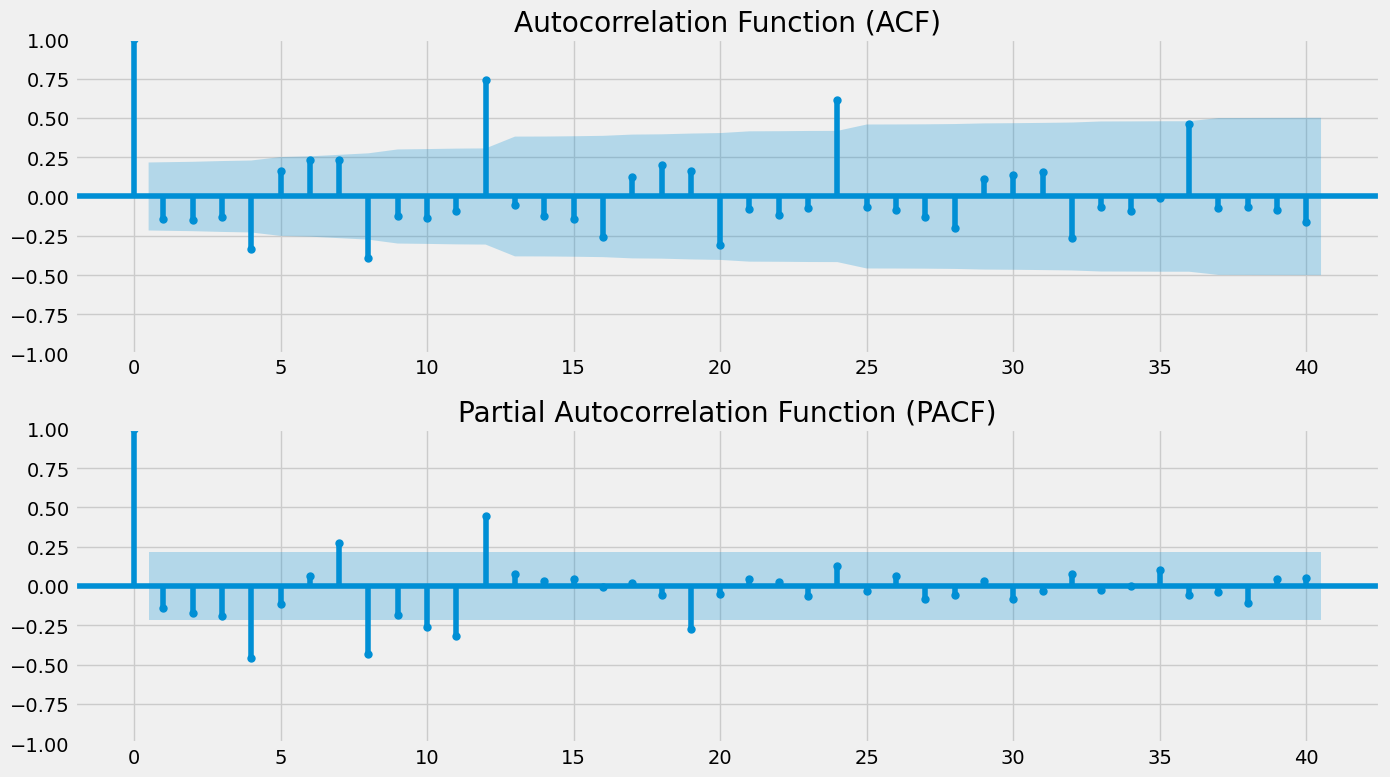

In [81]:
# Add a 'Date' column with monthly periods starting from '01/03/1964'
df['Date'] = pd.date_range(start='01/03/1964', periods=len(df), freq='M')
df.set_index('Date', inplace=True)

# Define the split point (80% for training, 20% for testing)
split_point = int(len(df) * 0.8)
train, test = df[:split_point], df[split_point:]

# Plot ACF and PACF for the transformed sales data
fig, ax = plt.subplots(2, 1, figsize=(14, 8))

# ACF plot
sm.graphics.tsa.plot_acf(train['Sales_Transformed_Diff'], lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
sm.graphics.tsa.plot_pacf(train['Sales_Transformed_Diff'], lags=40, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [82]:
# Define a function to find the best ARIMA model
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

In [83]:
# Evaluate combinations of p, d, q values for an ARIMA model
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mse = evaluate_arima_model(train['Sales_Transformed_Diff'], order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                print('ARIMA%s MSE=%.3f' % (order, mse))
            except:
                continue
print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


ARIMA(0, 0, 0) MSE=0.041
ARIMA(0, 0, 1) MSE=0.043
ARIMA(0, 0, 2) MSE=0.032
ARIMA(0, 1, 0) MSE=0.097
ARIMA(0, 1, 1) MSE=0.041
ARIMA(0, 1, 2) MSE=0.044
ARIMA(0, 2, 0) MSE=0.299
ARIMA(0, 2, 1) MSE=0.098
ARIMA(0, 2, 2) MSE=0.042
ARIMA(1, 0, 0) MSE=0.040
ARIMA(1, 0, 1) MSE=0.033
ARIMA(1, 0, 2) MSE=0.035
ARIMA(1, 1, 0) MSE=0.070
ARIMA(1, 1, 1) MSE=0.040
ARIMA(1, 1, 2) MSE=0.041
ARIMA(1, 2, 0) MSE=0.165
ARIMA(1, 2, 1) MSE=0.071
ARIMA(1, 2, 2) MSE=0.066
ARIMA(2, 0, 0) MSE=0.040
ARIMA(2, 0, 1) MSE=0.031
ARIMA(2, 0, 2) MSE=0.033
ARIMA(2, 1, 0) MSE=0.060
ARIMA(2, 1, 1) MSE=0.040
ARIMA(2, 1, 2) MSE=0.039
ARIMA(2, 2, 0) MSE=0.110
ARIMA(2, 2, 1) MSE=0.061
ARIMA(2, 2, 2) MSE=0.063
Best ARIMA(2, 0, 1) MSE=0.031


                                 SARIMAX Results                                  
Dep. Variable:     Sales_Transformed_Diff   No. Observations:                   82
Model:                     ARIMA(2, 0, 1)   Log Likelihood                  51.569
Date:                    Wed, 28 Aug 2024   AIC                            -93.139
Time:                            05:34:18   BIC                            -81.105
Sample:                        01-31-1964   HQIC                           -88.307
                             - 10-31-1970                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.590      0.010       0.000       0.003
ar.L1          0.4896      0.128      3.838      0.000       0.240       0.740
ar.L2         -0.228

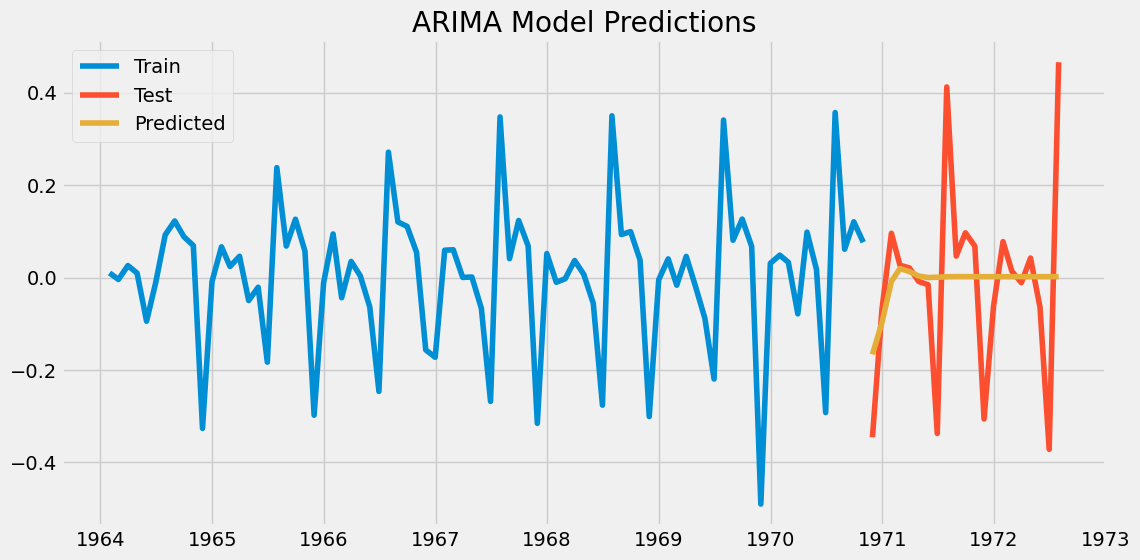

In [84]:
# Fit the best ARIMA model
arima_model = ARIMA(train['Sales_Transformed_Diff'], order=best_cfg)
arima_results = arima_model.fit()

# Print the model summary
print(arima_results.summary())

# Predict on the test set
y_pred = arima_results.forecast(steps=len(test))

# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales_Transformed_Diff'], label='Train')
plt.plot(test.index, test['Sales_Transformed_Diff'], label='Test')
plt.plot(test.index, y_pred, label='Predicted')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show()

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 MSE=0.041
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 MSE=0.023
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 MSE=0.005
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 MSE=0.005
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 MSE=0.006
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 MSE=0.005
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 MSE=0.005
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 MSE=0.005
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 MSE=0.045
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 MSE=0.016
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 MSE=0.005
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 MSE=0.005
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 MSE=0.005
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 MSE=0.005
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 MSE=0.005
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 MSE=0.005
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 MSE=0.097
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 MSE=0.062
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 MSE=0.014
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 MSE=0.013
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 MSE=0.016
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 MSE=0.010
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 MSE=0.012
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 MS

 This problem is unconstrained.


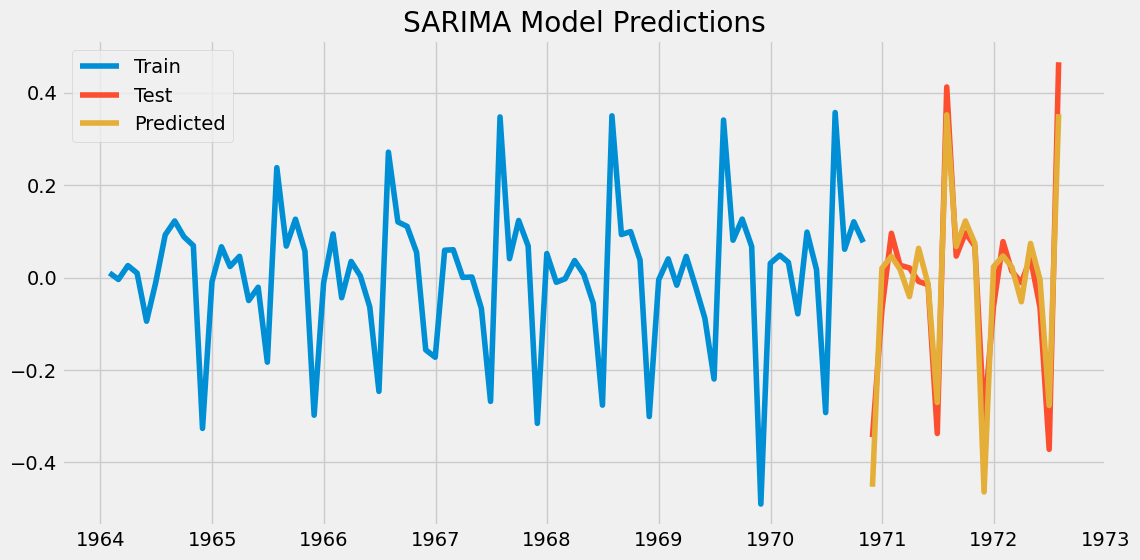

In [85]:
# Define a function to find the best SARIMA model
def evaluate_sarima_model(X, arima_order, seasonal_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order=arima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

# Evaluate combinations of p, d, q values for a SARIMA model
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Assuming monthly seasonal period (12)

best_score, best_cfg, best_seasonal_cfg = float("inf"), None, None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mse = evaluate_sarima_model(train['Sales_Transformed_Diff'], param, param_seasonal)
            if mse < best_score:
                best_score, best_cfg, best_seasonal_cfg = mse, param, param_seasonal
            print('SARIMA%sx%s12 MSE=%.3f' % (param, param_seasonal, mse))
        except:
            continue
print('Best SARIMA%sx%s12 MSE=%.3f' % (best_cfg, best_seasonal_cfg, best_score))

# Fit the best SARIMA model
sarima_model = SARIMAX(train['Sales_Transformed_Diff'], order=best_cfg, seasonal_order=best_seasonal_cfg, enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()

# Print the model summary
print(sarima_results.summary())

# Predict on the test set
y_pred = sarima_results.forecast(steps=len(test))

# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales_Transformed_Diff'], label='Train')
plt.plot(test.index, test['Sales_Transformed_Diff'], label='Test')
plt.plot(test.index, y_pred, label='Predicted')
plt.legend()
plt.title('SARIMA Model Predictions')
plt.show()


In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 CV MSE=0.024
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 CV MSE=0.017
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 CV MSE=0.006
Error for SARIMA(0, 0, 0)x(0, 1, 1, 12): too many indices for array: array is 0-dimensional, but 1 were indexed
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 CV MSE=0.007
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 CV MSE=0.008
Error for SARIMA(0, 0, 0)x(1, 1, 0, 12): too many indices for array: array is 0-dimensional, but 1 were indexed
Error for SARIMA(0, 0, 0)x(1, 1, 1, 12): too many indices for array: array is 0-dimensional, but 1 were indexed
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 CV MSE=0.027
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 CV MSE=0.016
Error for SARIMA(0, 0, 1)x(0, 1, 0, 12): too many indices for array: array is 0-dimensional, but 1 were indexed
Error for SARIMA(0, 0, 1)x(0, 1, 1, 12): too many indices for array: array is 0-dimensional, but 1 were indexed
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 CV MSE=0.006
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 CV MSE=0.006
Error for SARIMA(0, 0, 1)x(1, 1, 0,

 This problem is unconstrained.


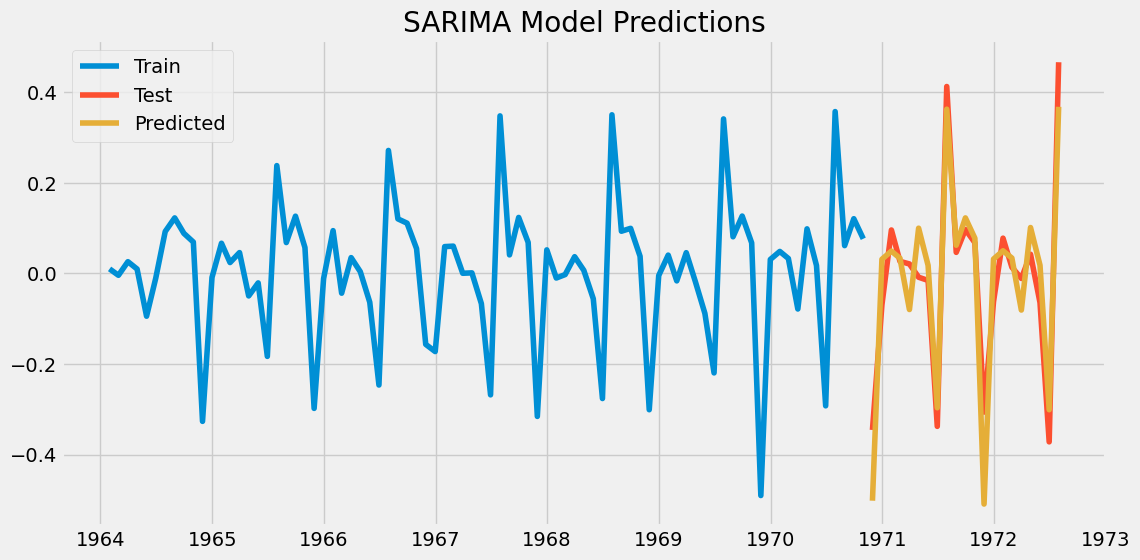

MSE: 0.0069438184760008
RMSE: 0.08332957743803096
MAPE: 176.15648415370723%


In [88]:
# Define a function to perform cross-validation
def sarima_cross_validation(data, pdq, seasonal_pdq, cv=5):
    n = len(data)
    fold_size = n // cv
    errors = []
    
    for i in range(cv):
        train_end = n - (cv - i) * fold_size
        train_data = data[:train_end]
        val_data = data[train_end:train_end + fold_size]
        
        history = [x for x in train_data]
        predictions = list()
        
        for t in range(len(val_data)):
            model = SARIMAX(history, order=pdq, seasonal_order=seasonal_pdq, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(val_data[t])
        
        mse = mean_squared_error(val_data, predictions)
        errors.append(mse)
    
    return np.mean(errors)

# Define parameter grid for SARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Assuming monthly seasonal period (12)

best_score, best_cfg, best_seasonal_cfg = float("inf"), None, None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            cv_score = sarima_cross_validation(train['Sales_Transformed_Diff'], param, param_seasonal, cv=5)
            if cv_score < best_score:
                best_score, best_cfg, best_seasonal_cfg = cv_score, param, param_seasonal
            print('SARIMA%sx%s12 CV MSE=%.3f' % (param, param_seasonal, cv_score))
        except Exception as e:
            print(f'Error for SARIMA{param}x{param_seasonal}: {e}')
            continue

print('Best SARIMA%sx%s12 CV MSE=%.3f' % (best_cfg, best_seasonal_cfg, best_score))

# Fit the best SARIMA model
sarima_model = SARIMAX(train['Sales_Transformed_Diff'], order=best_cfg, seasonal_order=best_seasonal_cfg, enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()

# Print the model summary
print(sarima_results.summary())

# Predict on the test set
y_pred = sarima_results.forecast(steps=len(test))

# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales_Transformed_Diff'], label='Train')
plt.plot(test.index, test['Sales_Transformed_Diff'], label='Test')
plt.plot(test.index, y_pred, label='Predicted')
plt.legend()
plt.title('SARIMA Model Predictions')
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test['Sales_Transformed_Diff'], y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Sales_Transformed_Diff'], y_pred)
mape = np.mean(np.abs((test['Sales_Transformed_Diff'] - y_pred) / test['Sales_Transformed_Diff'])) * 100

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
#print(f'MAE: {mae}')
print(f'MAPE: {mape}%')


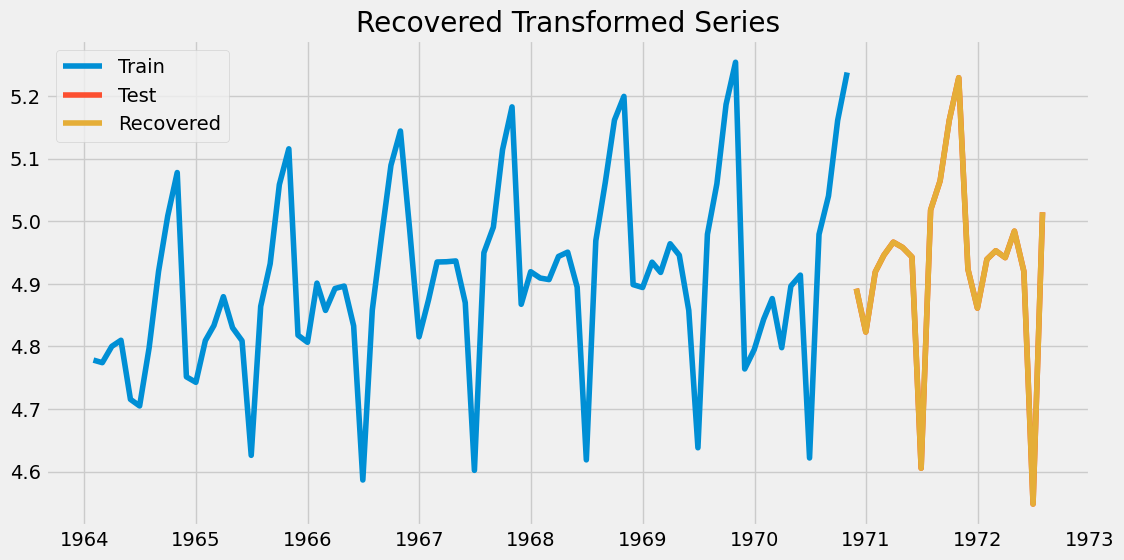

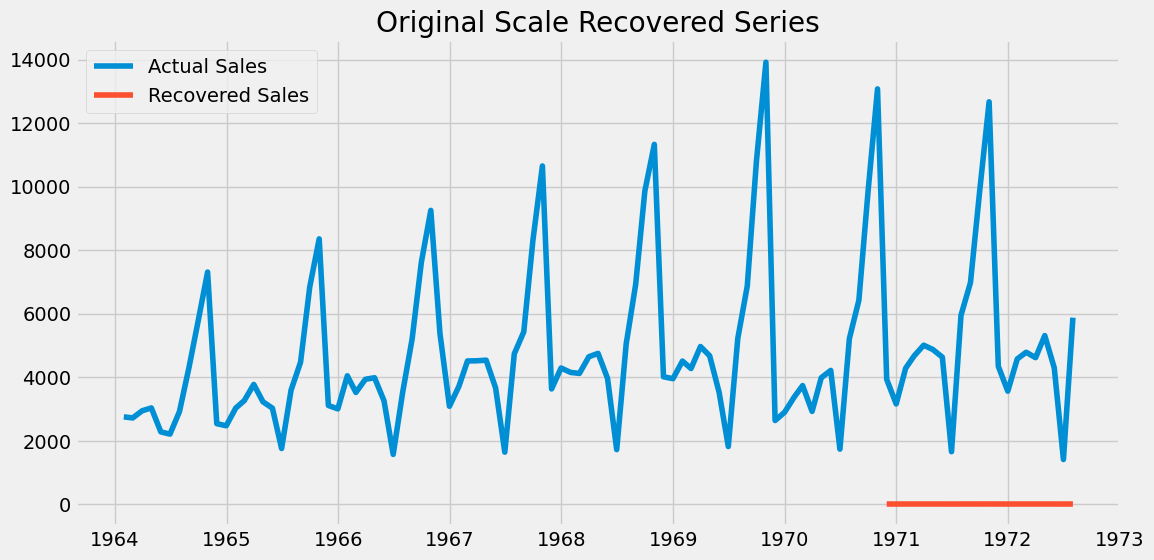

In [89]:
# Reverse the differencing to recover the transformed series
test['Sales_Transformed_Recovered'] = test['Sales_Transformed_Diff'].cumsum()
test['Sales_Transformed_Recovered'] += train['Sales_Transformed'].iloc[-1]

# Plot the recovered transformed series against the original transformed series
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales_Transformed'], label='Train')
plt.plot(test.index, test['Sales_Transformed'], label='Test')
plt.plot(test.index, test['Sales_Transformed_Recovered'], label='Recovered')
plt.legend()
plt.title('Recovered Transformed Series')
plt.show()

# Apply the inverse Box-Cox transformation
fitted_lambda = 0.5  # value for fitted_lambda; replace with the actual value used in Box-Cox transformation
test['Sales_Original_Scale_Recovered'] = inv_boxcox(test['Sales_Transformed_Recovered'], fitted_lambda)

# Plot the original scale recovered series against the actual sales
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales_Original_Scale'], label='Actual Sales')
plt.plot(test.index, test['Sales_Original_Scale_Recovered'], label='Recovered Sales')
plt.legend()
plt.title('Original Scale Recovered Series')
plt.show()